# What could be the year compensation of a data scientist ?

Kaggle hosted an open data scientist competition titled “2018 Kaggle ML & DS Survey Challenge.” The purpose of this challenge is to “tell a data story about a subset of the data science community represented in this survey, through a combination of both narrative text and data exploration.” 
https://www.kaggle.com/kaggle/kaggle-survey-2018

The purpose of this project is to
1. understand and explore employment in the data science community, as represented in a survey conducted by Kaggle.
2. train, validate, and tune multiple regressors that can predict, given a set of survey responses by a data scientist, what a survey respondent’s current yearly compensation is.

The dataset "Kaggle_Salary.csv" is a modified version of the survey results presented by Kaggle in the file "mutiplechoiceResponses.csv." For more details about the datase refers to the README.md

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install lxml
#!pip install beautifulsoup4
#!pip install sklearn

In [2]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import lxml.html.clean as chtml
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from PIL import Image
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# 1. DATA CLEANING

In [3]:
# Import dataset file and macth column with question as a reference. For instance, "Q1 = What is your gender? - Selected Choice"
salary_survey=pd.read_csv('Kaggle_Salary.csv') #This is the faster option to import the file and make a data frame


There is an error since the data has different formats. This error will be fixed by dropping some columns, rows, and encoding the information for categorical data. This will improve the analysis since the information feeding our model will be in a format readable for the model.

In [4]:
# Printing the initial dataset to have an idea of the data and variables.
salary_survey.head()

,Unnamed: 0,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT,index
0,0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,NaN
1,2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.0
2,3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,...,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.0
3,5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,...,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,2.0
4,7,959,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,1,...,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1,3.0


In [5]:
salary_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15430 entries, 0 to 15429
Columns: 397 entries, Unnamed: 0 to index
dtypes: float64(1), int64(1), object(395)
memory usage: 46.7+ MB


In [6]:
# It is always important to have an initial idea of any missing values, which will be reprsented with NaN or None.
missing_values_count = salary_survey.isnull().sum()
missing_values_count

Unnamed: 0                                 0
Time from Start to Finish (seconds)        0
Q1                                         0
Q1_OTHER_TEXT                              0
Q2                                         0
                                       ...  
Q50_Part_6                             14667
Q50_Part_7                             13635
Q50_Part_8                             15037
Q50_OTHER_TEXT                             0
index                                      1
Length: 397, dtype: int64

### Dropping Columns
In my first inspection of the dataset, I decided to DROP columns that do not add any value.

For instance "Duration in Seconds" that represents how long the participant spent filling this survey.

There are several columns with numbers -1, there was not an explanation of this data. After an analysis of these columns, I realized that "Q#_OTHER TEXT" represents the number of characters that a participant enters when he or she chooses the option OTHER. If a participant chooses an available option from the multiple choice question this column has -1 otherwise this column will have the numer of characters of the text entered by the participant.

These columns do not add any value to the analysis and it is better to drop them at the cleaning stage. I dropped all the columns with "OTHER TEXT" in their labels.

Other columns that do not add any value are columns that count the number of characters of the text response. For instance Q12 is a multiple choice question that includes text reponse. I dropped  Q12_Part_2_TEXT until Q12_Part_5_TEXT since we do not have the text entered by the user in our dataset to match with the number of characters

##### PROS AND CONS
1. Dropping columns that not add any value to the analysis has a positive impact because reduce the data size and eliminates noise and errors in our predictions. Useless data is unique, discrete data with no potential relationship with the outcome variable. 

In [7]:
# At first look, I decided to DROP columns that do not add any value. For instance "Duration in Seconds" 
data_salary=salary_survey.copy()
data_salary = data_salary.drop(columns=['Unnamed: 0','Time from Start to Finish (seconds)','index'])
# Also, columns "Q#_OTHER TEXT" present the number of characterest that a participant enters when he or she chooses the option OTHER.
# These columns do not add any value to the analysis and it is better to drop them at the cleaning stage.
data_salary = data_salary[data_salary.columns.drop(list(data_salary.filter(regex='OTHER_TEXT')))]

In [8]:
# Other columns that do not add any value are columns that count the number of characters of the text response. 
# For instance Q12 is a multiple choice question that includes text reponse. 
# I dropped  Q12_Part_2_TEXT until Q12_Part_5_TEXT since we do not have the text entered by the user in our dataset to match with
# the number of characters
data_salary = data_salary[data_salary.columns.drop(list(data_salary.filter(regex='Q12_Part')))]

In [9]:
# Drop the row that contains the description of the question. In case we need to recall the question, it is possible 
# to identify the question by using salary_survey.head()
questions = data_salary.iloc[0,:]
data_salary=data_salary.drop(data_salary.index[0])
# Change target varible to integer
data_salary['Q9']=data_salary['Q9'].astype('int')
data_salary=data_salary.reset_index(level=0, drop=True)


In [10]:
data_salary.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q49_Part_11,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8
0,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,18668,No (we do not use ML methods),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,2726,I do not know,...,NaN,NaN,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN
2,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,682,I do not know,...,NaN,NaN,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN
3,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,11957,No (we do not use ML methods),...,NaN,NaN,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN
4,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,2696,"We recently started using ML methods (i.e., mo...",...,NaN,NaN,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN


In [11]:
#Printing the questions to have as a record
questions.head()

Q1               What is your gender? - Selected Choice
Q2                          What is your age (# years)?
Q3            In which country do you currently reside?
Q4    What is the highest level of formal education ...
Q5    Which best describes your undergraduate major?...
Name: 0, dtype: object

The dataset after dropping columns that not add any value to the analysis is "data_salary" and it will be used to do encoding of catergorical data and missing values

### Encoding Categorical Data

Data generally needs to be put into numeric form for machine learning algorithms to use the data to make predictions. In machine learning guides categorical string data is usually one-hot-encoded

There are several questions that use categorical data in this dataset. In my first analysis of the dataset, I decided that I am not using all 50 questions to implement my models to predict, given a set of survey responses by a data scientist, what a survey respondent’s current yearly compensation is. 

For instance, Questions 39 ( How do you perceive the quality of online learning platforms) and 40 (What do you find most difficult) are opinions that help for data exploration and explaning what the data scientist comunity is currently thinking. 

However, I do not think those questions will be a great feature for predicting compensation. The explanation of what features I will be using is described in detail on the Feature Selection section. Therefore, I will apply encoding methods to columns that I might use in the feature selection and model preparation sections. If it is necessary to add other features, I wil come back to encode other features.

On the other hand, I will be using all 50 questions for data explorations and find some insights to tell a story about the data science communty. 

In [12]:
# Print info about the type of data to have an idea of the dataframe
print(data_salary.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15429 entries, 0 to 15428
Columns: 360 entries, Q1 to Q50_Part_8
dtypes: int32(1), object(359)
memory usage: 42.3+ MB
None


Nominal data such as gender, country, education, position, industry, consider yourself a data scientist, etc are values with no numerical relationship between the different categories — mean and median are meaningless. It is possible to enconde using one-hot-encode, label encoding or hash nominal features and the assigning of values would be random. 

NOTE: For nominal columns it is possible to try OneHot, Hashing, LeaveOneOut, and Target encoding. It is recomendable to avoid OneHot for high cardinality columns and decision tree-based algorithms.

Interval data such as age, years of experience, time spend coding, years of experience coding for data analysis, years using machine learning methods, proportion of your time spend in different stages of machine learning process, etc do not represent a temporal pattern. For interval data, there are a couple of options such us create bins to cut down on the number of ranges and reduce dimensionaly of the data set or use the media of the range as value.

##### LABEL ENCODING
FOR GENDER I WILL USE REPLACE VALUES

I will start with the most basic method, which is just replacing the categories with the desired numbers. It is possible to apply this method since the number of categories is small and I know all of them.
Gender has 4 categories. In order to reduce dimenstionaly I will enconde only 3 categories Male = 1, Female = 2, and Prefer no to say and Prefer to self-describe in a categore named Prefer self-describe = 3

In [13]:
# I make a copy of data_salary to encode categorical data.
data_label_encoding = data_salary.copy()
# Replace the nominal values by an integer as describe above
data_label_encoding=data_label_encoding.replace({'Q1': {'Male':1, 'Female': 2,'Prefer not to say':3,'Prefer to self-describe':3}})

FOR COUNTRY, EDUCATION, ROL, INDUSTRY I WILL USE LABEL ENCODING

Another approach is to encode categorical values with a technique called "label encoding", which allows to convert each value in a column to a number. Numerical labels are always between 0 and n_categories-1.


In [14]:
# Using the LabelEconder option from sklearn create a label maker and apply it to the columns.
# It will result in addition of new columns and then the categorical columns must be dropped.
lb_make = LabelEncoder()
# Country
data_label_encoding['Q3'] = lb_make.fit_transform(data_label_encoding['Q3'])
# Degree
data_label_encoding['Q4'] = lb_make.fit_transform(data_label_encoding['Q4'])
# Current Role
data_label_encoding['Q6'] = lb_make.fit_transform(data_label_encoding['Q6'])
# Industry
data_label_encoding['Q7'] = lb_make.fit_transform(data_label_encoding['Q7'])

##### PRO AND CONS
Country has 58 categories or diferente countries. Even thought applying one-hot encoding is recomendable for categorical data in this case one-hot enconding is not the best idea due to dimesionality. It will create 57 new columns and as we know some models with high dimensionality data do not perform very well. For that reason, I decided to try my model with label enconding

Q26 DO YOU CONSIDER YOURSELF TO BE A DATA SCIENTIST?

For this question, I will use label enconding. However, this question has missing values and I need to fix them fisrt to apply the enconding technique. In the Missing Value Section, I will explain in detail what techniques I am using for each feature, but usually to try to figure out why it is missing and if it will affect my analysis I use the following question. 

Is this value missing becuase it wasn't recorded or becuase it dosen't exist?

If a value is missing becuase it does not exist then it does not make sense to try and guess what it might be. I will probably keep these values as NaN. On the other hand, if a value is missing becuase it was not recorded, then I can try to "guess" what it might have been based on the other values in that column and row. 

Q26 Missing completely at random (MCAR) since I could not find any realthioship with other variables that can explain why these values are missing.


In [15]:
print(data_label_encoding['Q26'].isna().sum())

2023


In [16]:
# Q26 has 2023 missing values. 
# I will fill these NAN using the distribution of the other values. I do not want to drop these values because I think it will be
# a important feauture in my prediction model
# First, I print the initial distribution
r = data_label_encoding.Q26.value_counts(normalize=True)
print(r)

Probably yes      0.268164
Definitely yes    0.266000
Maybe             0.214009
Probably not      0.166418
Definitely not    0.085410
Name: Q26, dtype: float64


In [17]:
# The size needed and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_label_encoding['Q26'].isnull()
# Filling the values with a radom value from the normal distribution
data_label_encoding.loc[missing,'Q26'] = np.random.choice(r.index, size=len(data_label_encoding[missing]),p=r.values)

In [18]:
# Check if filling the missing values affect the initial distribution
t = data_label_encoding.Q26.value_counts(normalize=True)
print(t)

Probably yes      0.268261
Definitely yes    0.266187
Maybe             0.214596
Probably not      0.165014
Definitely not    0.085942
Name: Q26, dtype: float64


As the table above presents the disribution of the data is not affected dratically. For this reason, this approach will not affect the final analysis.

In [19]:
lb_make = LabelEncoder()
data_label_encoding['Q26'] = lb_make.fit_transform(data_label_encoding['Q26'])

In [20]:
# Q37 On which online platform have you spent the most amount of time? - Selected Choice
# I will fill these NAN using the distribution of the other values. I do not want to drop these values because I think it will be
# a important feauture in my prediction model
# First, I print the initial distribution
r = data_label_encoding.Q37.value_counts(normalize=True)
print(r)

Coursera                     0.395116
DataCamp                     0.125669
Udemy                        0.117986
Udacity                      0.086569
edX                          0.077651
Kaggle Learn                 0.062148
Online University Courses    0.047880
Other                        0.033749
Fast.AI                      0.028948
developers.google.com        0.011524
DataQuest                    0.010427
TheSchool.AI                 0.002332
Name: Q37, dtype: float64


In [21]:
# The size needed and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_label_encoding['Q37'].isnull()
# Filling the values with a radom value from the normal distribution
data_label_encoding.loc[missing,'Q37'] = np.random.choice(r.index, size=len(data_label_encoding[missing]),p=r.values)

In [22]:
lb_make = LabelEncoder()
data_label_encoding['Q37'] = lb_make.fit_transform(data_label_encoding['Q37'])

In [23]:
# Q48 Do you consider ML models to be "black boxes" with outputs that are difficult or impossible to explain?
# Q48 has 5415 mising values. That is a big number of entries that cannot be deleted
# # I will fill these NAN using the distribution of the other values. I do not want to drop these values because I think it will be
# a important feauture in my prediction model
# First, I print the initial distribution
r = data_label_encoding.Q48.value_counts(normalize=True)
print(r)

I am confident that I can understand and explain the outputs of many but not all ML models             0.495506
I view ML models as "black boxes" but I am confident that experts are able to explain model outputs    0.216097
Yes, most ML models are "black boxes"                                                                  0.121530
I am confident that I can explain the outputs of most if not all ML models                             0.090174
I do not know; I have no opinion on the matter                                                         0.076693
Name: Q48, dtype: float64


In [24]:
# The size needed and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_label_encoding['Q48'].isnull()
# Filling the values with a radom value from the normal distribution
data_label_encoding.loc[missing,'Q48'] = np.random.choice(r.index, size=len(data_label_encoding[missing]),p=r.values)

In [25]:
# label enconding for Q48
lb_make = LabelEncoder()
data_label_encoding['Q48'] = lb_make.fit_transform(data_label_encoding['Q48'])

In [26]:
data_label_encoding

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q49_Part_11,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8
0,1,30-34,22,0,Engineering (non-computer focused),11,9,5-10,18668,No (we do not use ML methods),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,30-34,56,3,"Computer science (software engineering, etc.)",7,7,0-1,2726,I do not know,...,NaN,NaN,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN
2,1,22-24,21,3,Mathematics or statistics,4,7,0-1,682,I do not know,...,NaN,NaN,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN
3,1,35-39,8,1,"Information technology, networking, or system ...",11,0,10-15,11957,No (we do not use ML methods),...,NaN,NaN,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN
4,1,18-21,21,3,"Information technology, networking, or system ...",11,16,0-1,2696,"We recently started using ML methods (i.e., mo...",...,NaN,NaN,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15424,1,30-34,32,3,"Computer science (software engineering, etc.)",17,3,10-15,90274,We are exploring ML methods (and may one day p...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15425,1,22-24,43,3,Mathematics or statistics,19,7,0-1,5508,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15426,1,30-34,53,1,"Computer science (software engineering, etc.)",14,0,5-10,15180,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15427,1,45-49,15,1,"Computer science (software engineering, etc.)",1,3,5-10,253671,"We recently started using ML methods (i.e., mo...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### INTERVAL CATEGORICAL DATA

Ranges of values for observation points, for example, the age column is described in the form of categories like 0-20, 20-40 and so on. There can be a lot of ways to deal with such features, the most common ones are either split these ranges into two separate columns or replace them with some measure like the mean of that range.

In this case, I am using mean of the interval as method to enconde intervals. I will use a formula that split the column on the delimeter - into two columns start and end using split() and then it calculates the mean of the range. Pros and cons are discuss in the section PROS AND CONS OF ENCODING METHOD USED

In [27]:
# I create a copy of the data after the first label encoding step
data_interval_encoding = data_label_encoding.copy()

In [28]:
# To replace the range with its mean, I will write a split_mean() function which basically takes one range at a time, splits it,
# then calculates the mean and returns it. 

def split_mean(x):
    split_list = x.split('-')
    mean = (float(split_list[0])+float(split_list[1]))/2
    return mean

In [29]:
# Q2 AGE
# Print the intervals to have an initial idea 
print(data_interval_encoding['Q2'].value_counts())

25-29    4278
22-24    2894
30-34    2819
35-39    1637
18-21    1363
40-44     989
45-49     602
50-54     403
55-59     222
60-69     180
70-79      26
80+        16
Name: Q2, dtype: int64


In [30]:
# First encoding before applying the mean calculation formula
data_interval_encoding = data_interval_encoding.replace({'Q2': {'80+':'80-90'}})
# I am deleting the + besides the 80+, since it is more that 80 I am writting 80-90 that does nof affect my analysis since it 
# is still bigger that 80

In [31]:
# Apply mean formula in the whole column Q2 to change the interval for the mean of each interval
data_interval_encoding['Q2']= data_interval_encoding['Q2'].apply(lambda x: split_mean(x))

In [32]:
# Q8 YEARS OF EXPERIENCE
# Print the intervals to have an initial idea 
print(data_interval_encoding['Q8'].value_counts())

0-1      3879
1-2      2826
5-10     1973
2-3      1965
3-4      1308
4-5      1145
10-15    1123
15-20     595
20-25     271
30 +      144
25-30     124
Name: Q8, dtype: int64


In [33]:
# First encoding before applying the mean calculation formula
data_interval_encoding = data_interval_encoding.replace({'Q8': {'30 +':'30-30'}})
# I am deleting the + besides the 30+, since it is more that 30 I am writting 80-30 that does nof affect my analysis since it 
# is still bigger that 30

In [34]:
# Apply mean formula in the whole column Q8 to change the interval for the mean of each interval
data_interval_encoding['Q8'] = data_interval_encoding['Q8'].astype('category')
data_interval_encoding['Q8']= data_interval_encoding['Q8'].apply(lambda x: split_mean(x))

In [35]:
#Q23 PERCENTAGE OF TIME CODING
# Print the intervals to have an initial idea 
#Approximately what percent of your time at work or school is spent actively coding?
print(data_interval_encoding['Q23'].value_counts())

50% to 74% of my time    4036
25% to 49% of my time    3571
1% to 25% of my time     3013
75% to 99% of my time    2141
0% of my time             360
100% of my time           340
Name: Q23, dtype: int64


In [36]:
# First encoding before applying the mean calculation formula
data_interval_encoding = data_interval_encoding.replace({'Q23': {'50% to 74% of my time':'50-74','25% to 49% of my time':'25-49',
                                                                 '1% to 25% of my time':'2-3',
                                                                '1-25':'3-4','75% to 99% of my time':'75-99',
                                                                 '0% of my time':'0-0',
                                                                 '100% of my time':'100-100'}})
# Mean formula cannot read % symbol so I am deleting this symbols and encoding as number intervals

In [37]:
# Apply mean formula in the whole column Q23 to change the interval for the mean of each interval
data_interval_encoding['Q23']=data_interval_encoding['Q23'].astype('category')
data_interval_encoding['Q23']= data_interval_encoding['Q23'].apply(lambda x: split_mean(x))

In [38]:
#Q24 YEARS OF EXPERIENCE CODING
# Print the intervals to have an initial idea 
#How long have you been writing code to analyze data?
print(data_interval_encoding['Q24'].value_counts())

1-2 years                                               3785
3-5 years                                               3161
< 1 year                                                2927
5-10 years                                              1781
10-20 years                                              902
I have never written code but I want to learn            493
20-30 years                                              239
30-40 years                                               85
40+ years                                                 42
I have never written code and I do not want to learn      26
Name: Q24, dtype: int64


In [39]:
# First encoding before applying the mean calculation formula
data_interval_encoding = data_interval_encoding.replace({'Q24': {'< 1 year':'0-1','1-2 years':'1-2','3-5 years':'3-5',
                                                                '5-10 years':'5-10','10-20 years':'10-20',
                                                                 '20-30 years':'20-30','30-40 years':'30-40',
                                                                 '40+ years':'40-40',
                                                                 'I have never written code and I do not want to learn':'0-0',
                                                                'I have never written code but I want to learn':'0-0'}})
# Mean formula cannot read 'years' word so I am deleting this word and encoding as number intervals

In [40]:
# Apply mean formula in the whole column Q24 to change the interval for the mean of each interval
data_interval_encoding['Q24']=data_interval_encoding['Q24'].astype('category')
data_interval_encoding['Q24']= data_interval_encoding['Q24'].apply(lambda x: split_mean(x))

In [41]:
#Q25 YEARS USING MACHINE LEARNING METHODS
# Print the intervals to have an initial idea 
#For how many years have you used machine learning methods (at work or in school)?
print(data_interval_encoding['Q25'].value_counts())

< 1 year                                                                 4194
1-2 years                                                                3574
2-3 years                                                                1664
I have never studied machine learning but plan to learn in the future    1225
3-4 years                                                                 921
5-10 years                                                                743
4-5 years                                                                 650
10-15 years                                                               256
20+ years                                                                 129
I have never studied machine learning and I do not plan to                 59
Name: Q25, dtype: int64


In [42]:
# First encoding before applying the mean calculation formula
data_interval_encoding = data_interval_encoding.replace({'Q25': {'< 1 year':'0-1','1-2 years':'1-2','2-3 years':'2-3',
                                                                '3-4 years':'3-4','5-10 years':'5-10','4-5 years':'4-5',
                                                                 '10-15 years':'10-15', '20+ years':'20-20',
                                                                 'I have never studied machine learning and I do not plan to':'0-0',
                                                                'I have never studied machine learning but plan to learn in the future':'0-0'}})
# Mean formula cannot read 'years' word so I am deleting this word and encoding as number intervals

In [43]:
# Apply mean formula in the whole column Q25 to change the interval for the mean of each interval
data_interval_encoding['Q25']=data_interval_encoding['Q25'].astype('category')
data_interval_encoding['Q25']= data_interval_encoding['Q25'].apply(lambda x: split_mean(x))

In [44]:
#Q43 PERCENTAGE OF TIME EXPLORING UNFAIR BIAS
# Print the intervals to have an initial idea 
#Approximately what percent of your data projects involved exploring unfair bias in the dataset and/or algorithm?
print(data_interval_encoding['Q43'].value_counts())

0         2862
0-10      2482
10-20     1556
20-30     1119
30-40      519
40-50      452
50-60      256
60-70      206
70-80      159
90-100     159
80-90       84
Name: Q43, dtype: int64


In [45]:
# First encoding before applying the mean calculation formula
data_interval_encoding = data_interval_encoding.replace({'Q43': {'0':'0-0'}})
# I am just creating a 0 interval so the mean formula can work on these column

In [46]:
# Apply mean formula in the whole column Q43 to change the interval for the mean of each interval
data_interval_encoding['Q43']=data_interval_encoding['Q43'].astype('category')
data_interval_encoding['Q43']= data_interval_encoding['Q43'].apply(lambda x: split_mean(x))

In [47]:
#Q46 Approximately what percent of your data projects involve exploring model insights?
print(data_interval_encoding['Q46'].value_counts())

10-20     1574
0-10      1531
20-30     1416
0         1134
90-100     856
30-40      788
40-50      741
70-80      569
50-60      517
60-70      502
80-90      370
Name: Q46, dtype: int64


In [48]:
# First encoding before applying the mean calculation formula
data_interval_encoding = data_interval_encoding.replace({'Q46': {'0':'0-0'}})
# I am just creating a 0 interval so the mean formula can work on these column

In [49]:
# Apply mean formula in the whole column Q43 to change the interval for the mean of each interval
data_interval_encoding['Q46']=data_interval_encoding['Q46'].astype('category')
data_interval_encoding['Q46']= data_interval_encoding['Q46'].apply(lambda x: split_mean(x))

In [50]:
# Final dataframe after label and interval encoding.
data_interval_encoding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15429 entries, 0 to 15428
Columns: 360 entries, Q1 to Q50_Part_8
dtypes: category(6), float64(1), int32(8), int64(1), object(344)
memory usage: 41.3+ MB


##### ONE HOT ENCODING
One-Hot Encoding : The Standard Approach for Categorical Data which is the most widespread approach, and it works very well unless your categorical variable takes on a large number of values (i.e.generally it will not work very well for variables taking more than 15 different values. It would be a poor choice in some cases with fewer values, though that varies)

One hot encoding creates new (binary) columns, indicating the presence of each possible value from the original data. It is important to mention that I am avoiding OneHot for high cardinality columns.

I am going to use this method to encode questions where participants list a number of software or tools that they use as data scientist.

In [51]:
# I create a copy of the data after the interval encoding step
data_one_hot=data_interval_encoding.copy()

In [52]:
# Q10 Does your current employer incorporate machine learning methods into their business?
data_one_hot = pd.get_dummies(data_one_hot, columns=['Q10'])

In [53]:
# Q11 Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice
#Analyze and understand data to influence product or business decisions
#Build and/or run a machine learning service that operationally improves my product or workflows
#Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data
#Build prototypes to explore applying machine learning to new areas
#Do research that advances the state of the art of machine learning
#None of these activities are an important part of my role at work
#Other
# First encoding before applying the one hot encoding. I apply this step because the answers are long sentences and I just want to have
# number that represent each categorie
data_one_hot= data_one_hot.replace({'Q11_Part_1': {'Analyze and understand data to influence product or business decisions':'1'}})
data_one_hot= data_one_hot.replace({'Q11_Part_2': {'Build and/or run a machine learning service that operationally improves my product or workflows':'2'}})
data_one_hot= data_one_hot.replace({'Q11_Part_3': {'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data':'3'}})
data_one_hot= data_one_hot.replace({'Q11_Part_4': {'Build prototypes to explore applying machine learning to new areas':'4'}})
data_one_hot= data_one_hot.replace({'Q11_Part_5': {'Do research that advances the state of the art of machine learning':'5'}})
data_one_hot= data_one_hot.replace({'Q11_Part_6': {'None of these activities are an important part of my role at work':'6'}})
data_one_hot= data_one_hot.replace({'Q11_Part_7': {'Other':'7'}})

# I am just changing the sentence by a number between 1 and 7

In [54]:
# Creating the ONE-HOT ENCODING for Q11
data_one_hot = pd.get_dummies(data_one_hot, columns=['Q11_Part_1','Q11_Part_2','Q11_Part_3','Q11_Part_4','Q11_Part_5',
                                                     'Q11_Part_6','Q11_Part_7'],prefix= ['Q11','Q11','Q11','Q11','Q11', 
                                                    'Q11','Q11',])
#With this step I am also dropping the original columns.

In [55]:
# Q12 What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice

# Slicing the dataset for Q12 with missing values
q12_null=data_one_hot[data_one_hot.Q12_MULTIPLE_CHOICE.isnull()]
print (q12_null.isna().sum())

Q1        0
Q2        0
Q3        0
Q4        0
Q5       34
         ..
Q11_3     0
Q11_4     0
Q11_5     0
Q11_6     0
Q11_7     0
Length: 365, dtype: int64


### NOTE:

It is important to highlight that all other questions after Q12 are in blank if Q12 is in black. In other words, when a partcipant did not answered Q12 the survey ends. Based on that fact, keeping 1572 entries do not make any sense since it does not add any information.Therefore, I will drop them. This action will not affect my analysis and I will have a result closer to the reality of this dataset. 1572 values is 10% of the dataset (15000 entries) and they do not present any information in questions 13 to questions 50 when Q12 is in blank, therefore; keeping those entries or deleted them do not make any change.

In [56]:
# Q12 has 1572 NaN values that I am dropping a detailed explanation is presented in the Missing Values Section.
data_one_hot=data_one_hot.dropna(subset=['Q12_MULTIPLE_CHOICE'])

In [57]:
# First label encode before one-hot enconding. I just changing sentences by numbers because I do not want to have long sentences
# as lable of my one hot encode columns.
lb_make = LabelEncoder()
#data_one_hot['Q12_MULTIPLE_CHOICE']=data_one_hot['Q12_MULTIPLE_CHOICE'].astype('category')
data_one_hot['Q12_MULTIPLE_CHOICE'] = lb_make.fit_transform(data_one_hot['Q12_MULTIPLE_CHOICE'])

In [58]:
# Creating the ONE-HOT ENCODING for Q12
data_one_hot = pd.get_dummies(data_one_hot, columns=['Q12_MULTIPLE_CHOICE'], prefix= ['Q12'])

In [59]:
# Q13 Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply)
 #Jupyter/IPython
 #RStudio
 #PyCharm
 #Visual Studio Code
 #nteract
 #Atom
 #MATLAB
 #Visual Studio
 #Notepad++
 #Sublime Text
 #Vim
 #IntelliJ
 #Spyder
 #None
 #Other

In [60]:
# Creating the ONE-HOT ENCODING for Q13
data_one_hot = pd.get_dummies(data_one_hot, columns=['Q13_Part_1','Q13_Part_2','Q13_Part_3','Q13_Part_4','Q13_Part_5','Q13_Part_6',
                                                     'Q13_Part_7','Q13_Part_8','Q13_Part_9','Q13_Part_10','Q13_Part_11','Q13_Part_12',
                                                     'Q13_Part_13','Q13_Part_14','Q13_Part_15'], prefix= ['Q13','Q13','Q13','Q13',
                                                     'Q13', 'Q13','Q13','Q13','Q13','Q13','Q13','Q13', 'Q13','Q13','Q13'])

In [61]:
# Q14 Which of the following hosted notebooks have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice
# Creating the ONE-HOT ENCODING for Q14
data_one_hot = pd.get_dummies(data_one_hot, columns=['Q14_Part_1','Q14_Part_2','Q14_Part_3','Q14_Part_4','Q14_Part_5','Q14_Part_6',
                                                     'Q14_Part_7','Q14_Part_8','Q14_Part_9','Q14_Part_10','Q14_Part_11'], prefix= ['Q14','Q14','Q14','Q14',
                                                     'Q14', 'Q14','Q14','Q14','Q14','Q14','Q14'])

In [62]:
# Q15 Which of the following cloud computing services have you used at work or school in the last 5 years? (Select all that apply)
# Google Cloud Platform (GCP)
# Amazon Web Services (AWS)
# Microsoft Azure
# IBM Cloud
# Alibaba Cloud
# I have not used any cloud providers
# Other

In [63]:
# Creating the ONE-HOT ENCODING for Q15
data_one_hot = pd.get_dummies(data_one_hot, columns=['Q15_Part_1','Q15_Part_2','Q15_Part_3','Q15_Part_4','Q15_Part_5',
                                             'Q15_Part_6','Q15_Part_7'],prefix= ['Q15','Q15','Q15','Q15','Q15', 'Q15','Q15'])

In [64]:
# Q17 What specific programming language do you use most often? - Selected Choice
# There are 2769 missing values out of 13857 left after dropping missing values en Q12
# To apply one-hot enconding I want to fill the missing values first.
# Since the percentage of missing values is representative I will fill these NAN using the distribution of the other values

# First, I print the initial distribution
s = data_one_hot.Q17.value_counts(normalize=True)
print(s)

Python                   0.529040
R                        0.137626
SQL                      0.090097
Java                     0.056187
C/C++                    0.041847
C#/.NET                  0.029672
Javascript/Typescript    0.027778
MATLAB                   0.022276
SAS/STATA                0.016144
PHP                      0.013438
Visual Basic/VBA         0.008568
Other                    0.008387
Scala                    0.007305
Bash                     0.004058
Ruby                     0.003788
Go                       0.003157
Julia                    0.000631
Name: Q17, dtype: float64


In [65]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_one_hot['Q17'].isnull()
# Filling the values with a radom value from the normal distribution
data_one_hot.loc[missing,'Q17'] = np.random.choice(s.index, size=len(data_one_hot[missing]),p=s.values)

In [66]:
# Check if filling the missing values affect the initial distribution
t = data_one_hot.Q17.value_counts(normalize=True)
print(t)

Python                   0.532150
R                        0.136177
SQL                      0.088908
Java                     0.056794
C/C++                    0.040990
C#/.NET                  0.028938
Javascript/Typescript    0.027639
MATLAB                   0.022155
SAS/STATA                0.015732
PHP                      0.013639
Other                    0.008804
Visual Basic/VBA         0.008371
Scala                    0.007361
Bash                     0.004619
Ruby                     0.003897
Go                       0.003247
Julia                    0.000577
Name: Q17, dtype: float64


As it is presented in the above tables, the distribution before and after filling the missing values did not change drastically. This process of missing values will not affect my analysis otherwise it will keep closer to the real data.

In [67]:
# Print the number of missing values after the missing process to confirm that it worked perfectly.
print(data_one_hot['Q17'].isna().sum())

0


In [68]:
# Creating the ONE-HOT ENCODING for Q17
data_one_hot = pd.get_dummies(data_one_hot, columns=['Q17'], prefix= ['Q17'])

In [69]:
# Q18 What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice
data_one_hot = pd.get_dummies(data_one_hot, columns=['Q18'], prefix= ['Q18'])

In [70]:
# Q20 Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice
# Q20 has 4197 missing values. I cannot drop them because it is a considerable amount of information and it will affect my analysis If I drop this much data.
# I will use the same approach that before for Q17
# To apply one-hot enconding I need to fill the missing values
# Since the percentage of missing values is representative I will fill these NAN using the distribution of the other values

# First, I print the initial distribution
r = data_one_hot.Q20.value_counts(normalize=True)
print(r)

Scikit-Learn    0.466460
TensorFlow      0.141408
Keras           0.127433
randomForest    0.047930
Xgboost         0.046377
Caret           0.045859
PyTorch         0.045445
Spark MLlib     0.016667
lightgbm        0.013251
H20             0.011905
Fastai          0.010559
Other           0.008799
mlr             0.004865
Caffe           0.004762
Mxnet           0.002692
Prophet         0.002484
catboost        0.002174
CNTK            0.000932
Name: Q20, dtype: float64


In [71]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_one_hot['Q20'].isnull()
# Filling the values with a radom value from the normal distribution
data_one_hot.loc[missing,'Q20'] = np.random.choice(r.index, size=len(data_one_hot[missing]),p=r.values)

In [72]:
# Check if filling the missing values affect the initial distribution
t = data_one_hot.Q20.value_counts(normalize=True)
print(t)

Scikit-Learn    0.467922
TensorFlow      0.139568
Keras           0.128888
randomForest    0.048640
Xgboost         0.045537
Caret           0.045031
PyTorch         0.044743
Spark MLlib     0.016887
lightgbm        0.014217
H20             0.012268
Fastai          0.010536
Other           0.008371
Caffe           0.004979
mlr             0.004330
Mxnet           0.002454
Prophet         0.002381
catboost        0.002237
CNTK            0.001010
Name: Q20, dtype: float64


In [73]:
# Creating the ONE-HOT ENCODING for Q20
data_one_hot = pd.get_dummies(data_one_hot, columns=['Q20'], prefix= ['Q20'])

In [74]:
# Q22 Of the choices that you selected in the previous question, which specific data visualization library or tool have you used the most? - Selected Choice

# Q22 has 4671 missing values. I cannot drop them because it is a considerable amount of information and it will affect my analysis If I drop this much data.
# I will use the same approach that before for Q17
# To apply one-hot enconding I need to fill the missing values
# Since the percentage of missing values is representative I will fill these NAN using the distribution of the other values

# First, I print the initial distribution
u = data_one_hot.Q22.value_counts(normalize=True)
print(u)

Matplotlib    0.535053
ggplot2       0.246789
Seaborn       0.106902
Plotly        0.046048
D3            0.021772
Shiny         0.018724
Other         0.009471
Bokeh         0.006858
Leaflet       0.003484
Lattice       0.002939
Altair        0.001089
Geoplotlib    0.000871
Name: Q22, dtype: float64


In [75]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_one_hot['Q22'].isnull()
# Filling the values with a radom value from the normal distribution
data_one_hot.loc[missing,'Q22'] = np.random.choice(u.index, size=len(data_one_hot[missing]),p=u.values)

In [76]:
# Check if filling the missing values affect the initial distribution
t = data_one_hot.Q22.value_counts(normalize=True)
print(t)

Matplotlib    0.534387
ggplot2       0.245941
Seaborn       0.107527
Plotly        0.047269
D3            0.021361
Shiny         0.018402
Other         0.009887
Bokeh         0.006711
Leaflet       0.003103
Lattice       0.003031
Altair        0.001299
Geoplotlib    0.001082
Name: Q22, dtype: float64


In [77]:
# Creating the ONE-HOT ENCODING for Q22
data_one_hot = pd.get_dummies(data_one_hot, columns=['Q22'], prefix= ['Q22'])

In [78]:
# Q27 Which of the following cloud computing products have you used at work or school in the last 5 years (Select all that apply)? - Selected Choice

# AWS Elastic Compute Cloud (EC2)
# Google Compute Engine
# AWS Elastic Beanstalk
# Google App Engine
# Google Kubernetes Engine
# AWS Lambda
# Google Cloud Functions
# AWS Batch
# Azure Virtual Machines
# Azure Container Service
# Azure Functions
# Azure Event Grid
# Azure Batch
# Azure Kubernetes Service
# IBM Cloud Virtual Servers
# IBM Cloud Container Registry
# IBM Cloud Kubernetes Service
# IBM Cloud Foundry
# None
# Other

# Create a copy of the dataframe for this step
#data=data_one_hot.copy()

# First one-hot encoding 
data_one_hot = pd.get_dummies(data_one_hot, columns=['Q27_Part_1','Q27_Part_2','Q27_Part_3','Q27_Part_4','Q27_Part_5',
                                             'Q27_Part_6','Q27_Part_7', 'Q27_Part_8','Q27_Part_9','Q27_Part_10','Q27_Part_11',
                                            'Q27_Part_12','Q27_Part_13','Q27_Part_14','Q27_Part_15','Q27_Part_16','Q27_Part_17',
                                            'Q27_Part_18','Q27_Part_19','Q27_Part_20'],prefix= ['Q27','Q27','Q27','Q27','Q27',
                                            'Q27','Q27','Q27','Q27','Q27','Q27','Q27', 'Q27','Q27','Q27','Q27','Q27','Q27','Q27', 'Q27'])


In [79]:
# Q28 Which of the following machine learning products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice

# First one-hot encoding 
data_one_hot = pd.get_dummies(data_one_hot, columns=['Q28_Part_1','Q28_Part_2','Q28_Part_3','Q28_Part_4','Q28_Part_5',
                    'Q28_Part_6','Q28_Part_7', 'Q28_Part_8','Q28_Part_9','Q28_Part_10','Q28_Part_11','Q28_Part_12',
                    'Q28_Part_13','Q28_Part_14','Q28_Part_15','Q28_Part_16','Q28_Part_17','Q28_Part_18','Q28_Part_19',
                    'Q28_Part_20', 'Q28_Part_21','Q28_Part_22','Q28_Part_23','Q28_Part_24','Q28_Part_25',
                    'Q28_Part_26','Q28_Part_27', 'Q28_Part_28','Q28_Part_29','Q28_Part_30','Q28_Part_31','Q28_Part_32',
                    'Q28_Part_33','Q28_Part_34','Q28_Part_35','Q28_Part_36','Q28_Part_37','Q28_Part_38','Q28_Part_39',
                    'Q28_Part_40', 'Q28_Part_41','Q28_Part_42','Q28_Part_43'], prefix= ['Q28','Q28','Q28','Q28','Q28',
                    'Q28','Q28','Q28','Q28','Q28','Q28','Q28', 'Q28','Q28','Q28','Q28','Q28','Q28','Q28', 'Q28',
                    'Q28','Q28','Q28','Q28','Q28','Q28','Q28','Q28','Q28','Q28','Q28','Q28','Q28','Q28','Q28', 
                    'Q28','Q28','Q28','Q28','Q28','Q28','Q28', 'Q28'])

In [80]:
# Q29 Which of the following relational database products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice 

# First one-hot encoding 
data_one_hot = pd.get_dummies(data_one_hot, columns=['Q29_Part_1','Q29_Part_2','Q29_Part_3','Q29_Part_4','Q29_Part_5',
                    'Q29_Part_6','Q29_Part_7', 'Q29_Part_8','Q29_Part_9','Q29_Part_10','Q29_Part_11','Q29_Part_12',
                    'Q29_Part_13','Q29_Part_14','Q29_Part_15','Q29_Part_16','Q29_Part_17','Q29_Part_18','Q29_Part_19',
                    'Q29_Part_20', 'Q29_Part_21','Q29_Part_22','Q29_Part_23','Q29_Part_24','Q29_Part_25',
                    'Q29_Part_26','Q29_Part_27', 'Q29_Part_28'],prefix= ['Q29','Q29','Q29','Q29','Q29',
                    'Q29','Q29','Q29','Q29','Q29','Q29','Q29', 'Q29','Q29','Q29','Q29','Q29','Q29','Q29', 'Q29',
                    'Q29','Q29','Q29','Q29','Q29','Q29','Q29','Q29'])


In [81]:
# Q30 Which of the following big data and analytics products have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice

# First one-hot encoding 
data_one_hot = pd.get_dummies(data_one_hot, columns=['Q30_Part_1','Q30_Part_2','Q30_Part_3','Q30_Part_4','Q30_Part_5',
'Q30_Part_6','Q30_Part_7', 'Q30_Part_8','Q30_Part_9','Q30_Part_10','Q30_Part_11','Q30_Part_12',
'Q30_Part_13','Q30_Part_14','Q30_Part_15','Q30_Part_16','Q30_Part_17','Q30_Part_18','Q30_Part_19',
'Q30_Part_20', 'Q30_Part_21','Q30_Part_22','Q30_Part_23','Q30_Part_24','Q30_Part_25'],prefix= ['Q30','Q30','Q30','Q30','Q30',
'Q30','Q30','Q30','Q30','Q30','Q30','Q30', 'Q30','Q30','Q30','Q30','Q30','Q30','Q30', 'Q30','Q30','Q30','Q30','Q30','Q30'])

#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### FEATURE ENGINEERING

Q27, Q28, Q29 and Q30 have many features (columns) that can be engineered in order to reduce the number of columns and avoid overfitting.  I will apply FEATURE ENGINEERING by grouping these categories depending of the product such as: Google, AWS, IBM Watson, Azure, etc.
This approach does not affect my analysis even thought I lose specific names regarding of the product that were mentioned 
in the survey.

In [82]:
data=data_one_hot.copy()

In [83]:
# Q27 has 20 options. In order to reduce the number of columns and avoid overfitting 
# I will apply FEATURE ENGINEERING by grouping these categories depending of the product such as:
# Google, AWS, IBM Watson, Azure, etc.
# This approach does not affect my analysis even thought I lose specific names regarding of the product that were mentioned 
# in the survey

# Gropu AWS
# AWS Elastic Compute Cloud (EC2)
# AWS Elastic Beanstalk
# AWS Lambda
# AWS Batch
data['Q27_AWS']=data['Q27_AWS Elastic Compute Cloud (EC2)'] | data['Q27_AWS Elastic Beanstalk'] | data ['Q27_AWS Lambda']| data['Q27_AWS Batch']

#Gropu IBM Cloud
# IBM Cloud Virtual Servers
# IBM Cloud Container Registry
# IBM Cloud Kubernetes Service
# IBM Cloud Foundry
data['Q27_IBM_Cloud']=data['Q27_IBM Cloud Virtual Servers'] | data['Q27_IBM Cloud Container Registry'] | data ['Q27_IBM Cloud Kubernetes Service']|data['Q27_IBM Cloud Foundry']

# Group Google
# Google Compute Engine
# Google App Engine
# Google Kubernetes Engine
# Google Cloud Functions
data['Q27_Google']=data['Q27_Google Compute Engine'] | data['Q27_Google App Engine'] | data ['Q27_Google Kubernetes Engine']| data ['Q27_Google Cloud Functions']

#Group Azure
# Azure Virtual Machines
# Azure Container Service
# Azure Functions
# Azure Event Grid
# Azure Batch
# Azure Kubernetes Service
data['Q27_Azure']=data['Q27_Azure Virtual Machines'] | data['Q27_Azure Container Service']| data ['Q27_Azure Functions']| data['Q27_Azure Event Grid'] | data ['Q27_Azure Batch']| data['Q27_Azure Kubernetes Service']

# None
data['Q27_None']=data['Q27_None']
# Other

In [84]:
# Once the new features are created, I need to delete repeat columns created by one-one encoding.
data=data.drop(columns=['Q27_AWS Elastic Compute Cloud (EC2)','Q27_Google Compute Engine','Q27_AWS Elastic Beanstalk','Q27_Google App Engine',
'Q27_Google Kubernetes Engine','Q27_AWS Lambda','Q27_Google Cloud Functions','Q27_AWS Batch','Q27_Azure Virtual Machines','Q27_Azure Container Service',
'Q27_Azure Functions','Q27_Azure Event Grid','Q27_Azure Batch','Q27_Azure Kubernetes Service','Q27_IBM Cloud Virtual Servers',
'Q27_IBM Cloud Container Registry','Q27_IBM Cloud Kubernetes Service','Q27_IBM Cloud Foundry'])


In [85]:
# Q28 has 43 choices. In order to reduce the number of columns and avoid overfitting 
# I will apply FEATURE ENGINEERING by grouping these categories depending of the product such as:
# Google, Amazon, IBM Watson, Azure, etc.
# This approach does not affect my analysis even thought I lose specific names regarding of the product that were mentioned in the survey

#DataRobot
#H20 Driverless AI
#Domino Datalab
#SAS
#Dataiku
#RapidMiner
#Instabase
#Algorithmia
#Dataversity
#Cloudera
#None
#Other

#Amazon Transcribe
#Amazon Rekognition
#Amazon Comprehend
#Amazon Translate
#Amazon Lex
#Amazon Rekognition Video
#Amazon SageMaker
data['Q28_Amazon']=data['Q28_Amazon Transcribe'] | data['Q28_Amazon Rekognition'] | data ['Q28_Amazon Comprehend']| data['Q28_Amazon Translate'] | data ['Q28_Amazon Lex']| data['Q28_Amazon Rekognition Video'] | data ['Q28_Amazon SageMaker']


#IBM Watson Studio
#IBM Watson Knowledge Catalog
#IBM Watson Assistant
#IBM Watson Discovery
#IBM Watson Text to Speech
#IBM Watson Visual Recognition
#IBM Watson Machine Learning
data['Q28_IBM_Watson']=data['Q28_IBM Watson Studio'] | data['Q28_IBM Watson Knowledge Catalog'] | data ['Q28_IBM Watson Assistant']|data['Q28_IBM Watson Discovery']|data['Q28_IBM Watson Text to Speech']|data['Q28_IBM Watson Visual Recognition']|data['Q28_IBM Watson Machine Learning']


#Google Cloud Vision API
#Google Cloud Natural Language API
#Google Cloud Translation API
#Google Dialogflow Enterprise Edition
#Google Cloud Video Intelligence API
#Google Cloud AutoML
#Google Cloud Machine Learning Engine
#Google Cloud Speech
data['Q28_Google']=data['Q28_Google Cloud Vision API'] | data['Q28_Google Cloud Natural Language API'] | data ['Q28_Google Cloud Speech-to-text API']


#Azure Machine Learning Studio
#Azure Machine Learning Workbench
#Azure Cortana Intelligence Suite
#Azure Bing Speech API
#Azure Speaker Recognition API
#Azure Computer Vision API
#Azure Face API
#Azure Video API
#Azure Cognitive Services
data['Q28_Azure']=data['Q28_Azure Machine Learning Studio'] | data['Q28_Azure Machine Learning Workbench'] | data ['Q28_Azure Cortana Intelligence Suite']| data['Q28_Azure Bing Speech API'] | data ['Q28_Azure Speaker Recognition API']| data['Q28_Azure Computer Vision API'] | data ['Q28_Azure Face API']| data['Q28_Azure Video API']|data['Q28_Azure Cognitive Services']


In [86]:
# Once the new features are created, I need to delete repeat columns created by one-one encoding.
data=data.drop(columns=['Q28_Amazon Transcribe','Q28_Amazon Rekognition','Q28_Amazon Comprehend','Q28_Amazon Translate',
'Q28_Amazon Lex','Q28_Amazon Rekognition Video','Q28_Amazon SageMaker','Q28_IBM Watson Studio',
'Q28_IBM Watson Knowledge Catalog','Q28_IBM Watson Assistant','Q28_IBM Watson Discovery','Q28_IBM Watson Text to Speech',
'Q28_IBM Watson Visual Recognition','Q28_IBM Watson Machine Learning','Q28_Google Cloud Vision API',
'Q28_Google Cloud Natural Language API','Q28_Google Cloud Translation API','Q28_Google Dialogflow Enterprise Edition',
'Q28_Google Cloud Video Intelligence API','Q28_Google Cloud AutoML','Q28_Google Cloud Machine Learning Engine',
'Q28_Google Cloud Speech-to-text API','Q28_Azure Machine Learning Studio','Q28_Azure Machine Learning Workbench',
'Q28_Azure Cortana Intelligence Suite','Q28_Azure Bing Speech API','Q28_Azure Speaker Recognition API',
'Q28_Azure Computer Vision API','Q28_Azure Face API','Q28_Azure Video API','Q28_Azure Cognitive Services'])


In [87]:
# Q29 has 28 options. In order to reduce the number of columns and avoid overfitting 
# I will apply FEATURE ENGINEERING by grouping these categories depending of the product such as: Google, AWS, IBM Cloud, Azure, etc.
# This approach does not affect my analysis even thought I am losing specific names regarding of the product that were mentioned
# in this survey

# MySQL
# PostgresSQL
# SQLite
# Oracle Database
# Ingres
# NexusDB
# SAP IQ
# None
# Other

# AWS Relational Database Service
# AWS Aurora
# AWS DynamoDB
# AWS SimpleDB
data['Q29_AWS']=data['Q29_AWS Relational Database Service'] | data['Q29_AWS Aurora'] | data ['Q29_AWS DynamoDB']| data['Q29_AWS SimpleDB'] 


# Google Cloud SQL
# Google Cloud Spanner
# Google Cloud Datastore
# Google Cloud Bigtable
# Google Fusion Tables
data['Q29_Google']=data['Q29_Google Cloud SQL'] | data['Q29_Google Cloud Spanner'] | data ['Q29_Google Cloud Datastore']| data['Q29_Google Cloud Bigtable'] | data ['Q29_Google Fusion Tables']


# Azure Database for MySQL
# Azure Cosmos DB
# Azure SQL Database
# Azure Database for PostgreSQL
data['Q29_Azure']=data['Q29_Azure Database for MySQL'] | data['Q29_Azure Cosmos DB'] | data ['Q29_Azure SQL Database']| data['Q29_Azure Database for PostgreSQL']


# IBM Cloud Compose
# IBM Cloud Compose for MySQL
# IBM Cloud Compose for PostgreSQL
# IBM Cloud Db2
data['Q29_IBM_Cloud']=data['Q29_IBM Cloud Compose'] | data['Q29_IBM Cloud Compose for MySQL'] | data ['Q29_IBM Cloud Compose for PostgreSQL']| data['Q29_IBM Cloud Db2']


# Microsoft SQL Server
# Microsoft Access
data['Q29_Microsoft']=data['Q29_Microsoft SQL Server'] | data['Q29_Microsoft Access']

In [88]:
# Once the new features are created, I need to delete repeat columns created by one-one encoding.
data=data.drop(columns=['Q29_AWS Relational Database Service','Q29_AWS Aurora','Q29_AWS DynamoDB','Q29_AWS SimpleDB','Q29_Google Cloud SQL',
'Q29_Google Cloud Spanner','Q29_Google Cloud Datastore','Q29_Google Cloud Bigtable','Q29_Google Fusion Tables','Q29_Azure Database for MySQL',
'Q29_Azure Cosmos DB','Q29_Azure SQL Database','Q29_Azure Database for PostgreSQL','Q29_IBM Cloud Compose','Q29_IBM Cloud Compose for MySQL',
'Q29_IBM Cloud Compose for PostgreSQL','Q29_IBM Cloud Db2','Q29_Microsoft SQL Server','Q29_Microsoft Access'])

In [89]:
# Q30 has 25 options. In order to reduce the number of columns and avoid overfitting 
# I will apply FEATURE ENGINEERING by grouping these categories depending of the product such as: Google, AWS, IBM Cloud, Azure, etc.
# This approach does not affect my analysis even thought I am losing specific names regarding of the product that were mentioned
# in this survey

# AWS Elastic MapReduce
# AWS Batch
# AWS Kinesis
# AWS Athena
# AWS Redshift
data['Q30_AWS']=data['Q30_AWS Elastic MapReduce'] | data['Q30_AWS Batch']| data['Q30_AWS Kinesis']| data['Q30_AWS Athena']| data['Q30_AWS Redshift']

# Google Cloud Dataproc
# Google Cloud Dataflow
# Google Cloud Dataprep
# Google Cloud Pub/Sub
# Google BigQuery
data['Q30_Google']=data['Q30_Google Cloud Dataproc'] | data['Q30_Google Cloud Dataflow']| data['Q30_Google Cloud Dataprep']| data['Q30_Google Cloud Pub/Sub']| data['Q30_Google BigQuery']

# Oracle Exadata
# Oracle Warehouse Builder
data['Q30_Oracle']=data['Q30_Oracle Exadata'] | data['Q30_Oracle Warehouse Builder']

# Azure SQL Data Warehouse
# Azure HDInsight
# Azure Stream Analytics
data['Q30_Azure']=data['Q30_Azure SQL Data Warehouse'] | data['Q30_Azure HDInsight']| data['Q30_Azure Stream Analytics']

# IBM InfoSphere DataStorage
# IBM Cloud Analytics Engine
# IBM Cloud Streaming Analytics
data['Q30_IBM']=data['Q30_IBM InfoSphere DataStorage'] | data['Q30_IBM Cloud Analytics Engine']| data['Q30_IBM Cloud Streaming Analytics']

# Teradata
# Microsoft Analysis Services
# SAP IQ
# Snowflake
# Databricks
# None
# Other


In [90]:
# Once the new features are created, I need to delete repeat columns created by one-one encoding.
data=data.drop(columns=['Q30_AWS Elastic MapReduce','Q30_AWS Batch','Q30_AWS Kinesis','Q30_AWS Athena',
'Q30_AWS Redshift','Q30_Google Cloud Dataproc','Q30_Google Cloud Dataflow','Q30_Google Cloud Dataprep','Q30_Google Cloud Pub/Sub',
'Q30_Google BigQuery','Q30_Oracle Exadata','Q30_Oracle Warehouse Builder','Q30_Azure SQL Data Warehouse','Q30_Azure HDInsight',
'Q30_Azure Stream Analytics','Q30_IBM InfoSphere DataStorage','Q30_IBM Cloud Analytics Engine','Q30_IBM Cloud Streaming Analytics',
])

#### END Feature Engineering

#### --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

writer = pd.ExcelWriter('output.xlsx')
data.to_excel(writer,'Sheet1')
writer.save()

### NOTE

Q34 has 3664 missing values that represents 25% of my dataset.
These values can be missing because they were not recorded during the survey. Reading more about the technique used during the survey it tells that no all the questions were asked to all participants. I am just assuming that these might be the reason why these values are missing.

I will not delete these entries but I will fill them up with a random number from the total distribution of each column. It might affect negatively my analysis but I do not want to lose important information in my analysis. Therefore; I will take the risk


In [91]:
# Q34 During a typical data science project at work or school, approximately what proportion of your time is devoted to the following? (Answers must add up to 100%)
# Q35 What percentage of your current machine learning/data science training falls under each category? (Answers must add up to 100%) 
# These questions are in a interval of 0-100 % in order to eliminate those percentage 
# I divide each value by 100 to scale these values

def scale_percetage(x):
    result=x/100
    return (result)

In [92]:
data_encoded=data.copy()
# First, I get the initial distribution
a = data_encoded.Q34_Part_1.value_counts(normalize=True)
b = data_encoded.Q34_Part_2.value_counts(normalize=True)
c = data_encoded.Q34_Part_3.value_counts(normalize=True)
d = data_encoded.Q34_Part_4.value_counts(normalize=True)
e = data_encoded.Q34_Part_5.value_counts(normalize=True)
f = data_encoded.Q34_Part_6.value_counts(normalize=True)

In [93]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_encoded['Q34_Part_1'].isnull()
# Filling the values with a radom value from the normal distribution
data_encoded.loc[missing,'Q34_Part_1'] = np.random.choice(a.index, size=len(data_encoded[missing]),p=a.values)

In [94]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_encoded['Q34_Part_2'].isnull()
# Filling the values with a radom value from the normal distribution
data_encoded.loc[missing,'Q34_Part_2'] = np.random.choice(b.index, size=len(data_encoded[missing]),p=b.values)

In [95]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_encoded['Q34_Part_3'].isnull()
# Filling the values with a radom value from the normal distribution
data_encoded.loc[missing,'Q34_Part_3'] = np.random.choice(c.index, size=len(data_encoded[missing]),p=c.values)

In [96]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_encoded['Q34_Part_4'].isnull()
# Filling the values with a radom value from the normal distribution
data_encoded.loc[missing,'Q34_Part_4'] = np.random.choice(d.index, size=len(data_encoded[missing]),p=d.values)

In [97]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_encoded['Q34_Part_5'].isnull()
# Filling the values with a radom value from the normal distribution
data_encoded.loc[missing,'Q34_Part_5'] = np.random.choice(e.index, size=len(data_encoded[missing]),p=e.values)

In [98]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_encoded['Q34_Part_6'].isnull()
# Filling the values with a radom value from the normal distribution
data_encoded.loc[missing,'Q34_Part_6'] = np.random.choice(f.index, size=len(data_encoded[missing]),p=f.values)

In [99]:
# Apply scale percentage formula in the whole column Q34 to change the scale the value
data_encoded['Q34_Part_1']=data_encoded['Q34_Part_1'].astype('float')
data_encoded['Q34_Part_2']=data_encoded['Q34_Part_2'].astype('float')
data_encoded['Q34_Part_3']=data_encoded['Q34_Part_3'].astype('float')
data_encoded['Q34_Part_4']=data_encoded['Q34_Part_4'].astype('float')
data_encoded['Q34_Part_5']=data_encoded['Q34_Part_5'].astype('float')
data_encoded['Q34_Part_6']=data_encoded['Q34_Part_6'].astype('float')

data_encoded['Q34_Part_1']= data_encoded['Q34_Part_1'].apply(lambda x: scale_percetage(x))
data_encoded['Q34_Part_2']= data_encoded['Q34_Part_2'].apply(lambda x: scale_percetage(x))
data_encoded['Q34_Part_3']= data_encoded['Q34_Part_3'].apply(lambda x: scale_percetage(x))
data_encoded['Q34_Part_4']= data_encoded['Q34_Part_4'].apply(lambda x: scale_percetage(x))
data_encoded['Q34_Part_5']= data_encoded['Q34_Part_5'].apply(lambda x: scale_percetage(x))
data_encoded['Q34_Part_6']= data_encoded['Q34_Part_6'].apply(lambda x: scale_percetage(x))

In [100]:
# Q35 During a typical data science project at work or school, approximately what proportion of your time is devoted to the following? (Answers must add up to 100%)
#I applied the same process for Q35
# First, I get the initial distribution
a = data_encoded.Q35_Part_1.value_counts(normalize=True)
b = data_encoded.Q35_Part_2.value_counts(normalize=True)
c = data_encoded.Q35_Part_3.value_counts(normalize=True)
d = data_encoded.Q35_Part_4.value_counts(normalize=True)
e = data_encoded.Q35_Part_5.value_counts(normalize=True)
f = data_encoded.Q35_Part_6.value_counts(normalize=True)

In [101]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_encoded['Q35_Part_1'].isnull()
# Filling the values with a radom value from the normal distribution
data_encoded.loc[missing,'Q35_Part_1'] = np.random.choice(a.index, size=len(data_encoded[missing]),p=a.values)

In [102]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_encoded['Q35_Part_2'].isnull()
# Filling the values with a radom value from the normal distribution
data_encoded.loc[missing,'Q35_Part_2'] = np.random.choice(b.index, size=len(data_encoded[missing]),p=b.values)

In [103]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_encoded['Q35_Part_3'].isnull()
# Filling the values with a radom value from the normal distribution
data_encoded.loc[missing,'Q35_Part_3'] = np.random.choice(c.index, size=len(data_encoded[missing]),p=c.values)

In [104]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_encoded['Q35_Part_4'].isnull()
# Filling the values with a radom value from the normal distribution
data_encoded.loc[missing,'Q35_Part_4'] = np.random.choice(d.index, size=len(data_encoded[missing]),p=d.values)

In [105]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_encoded['Q35_Part_5'].isnull()
# Filling the values with a radom value from the normal distribution
data_encoded.loc[missing,'Q35_Part_5'] = np.random.choice(e.index, size=len(data_encoded[missing]),p=e.values)

In [106]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_encoded['Q35_Part_6'].isnull()
# Filling the values with a radom value from the normal distribution
data_encoded.loc[missing,'Q35_Part_6'] = np.random.choice(f.index, size=len(data_encoded[missing]),p=f.values)

In [107]:
# Apply scale percentage formula in the whole column Q34 to change the scale the value
data_encoded['Q35_Part_1']=data_encoded['Q35_Part_1'].astype('float')
data_encoded['Q35_Part_2']=data_encoded['Q35_Part_2'].astype('float')
data_encoded['Q35_Part_3']=data_encoded['Q35_Part_3'].astype('float')
data_encoded['Q35_Part_4']=data_encoded['Q35_Part_4'].astype('float')
data_encoded['Q35_Part_5']=data_encoded['Q35_Part_5'].astype('float')
data_encoded['Q35_Part_6']=data_encoded['Q35_Part_6'].astype('float')

data_encoded['Q35_Part_1']= data_encoded['Q35_Part_1'].apply(lambda x: scale_percetage(x))
data_encoded['Q35_Part_2']= data_encoded['Q35_Part_2'].apply(lambda x: scale_percetage(x))
data_encoded['Q35_Part_3']= data_encoded['Q35_Part_3'].apply(lambda x: scale_percetage(x))
data_encoded['Q35_Part_4']= data_encoded['Q35_Part_4'].apply(lambda x: scale_percetage(x))
data_encoded['Q35_Part_5']= data_encoded['Q35_Part_5'].apply(lambda x: scale_percetage(x))
data_encoded['Q35_Part_6']= data_encoded['Q35_Part_6'].apply(lambda x: scale_percetage(x))

In [108]:
# Q40 Which better demonstrates expertise in data science: academic achievements or independent projects? - Your views:
# one-hot encoding 
# Q40 has 3763 missing values that represent 25% of the dataset
# It does not have any relationship with other variables that can explain why these values are missing. 
#These valueas are random missing valueas and I will fill the up using the distribution of data in this column.
r = data_encoded.Q40.value_counts(normalize=True)
print (r)

Independent projects are much more important than academic achievements        0.304903
Independent projects are slightly more important than academic achievements    0.289731
Independent projects are equally important as academic achievements            0.277387
Independent projects are slightly less important than academic achievements    0.053917
No opinion; I do not know                                                      0.052974
Independent projects are much less important than academic achievements        0.021087
Name: Q40, dtype: float64


In [109]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_encoded['Q40'].isnull()
# Filling the values with a radom value from the normal distribution
data_encoded.loc[missing,'Q40'] = np.random.choice(r.index, size=len(data_encoded[missing]),p=r.values)

In [110]:
# One-hot encoding for Q40
lb_make = LabelEncoder()
data_encoded['Q40'] = lb_make.fit_transform(data_encoded['Q40'])
data_encoded = pd.get_dummies(data_encoded, columns=['Q40'], prefix=['Q40'])

In [111]:
data_encoded.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q16_Part_1,...,Q30_Google,Q30_Oracle,Q30_Azure,Q30_IBM,Q40_0,Q40_1,Q40_2,Q40_3,Q40_4,Q40_5
0,1,32.0,22,0,Engineering (non-computer focused),11,9,7.5,18668,NaN,...,0,0,0,0,1,0,0,0,0,0
1,2,32.0,56,3,"Computer science (software engineering, etc.)",7,7,0.5,2726,NaN,...,0,0,0,0,1,0,0,0,0,0
2,1,23.0,21,3,Mathematics or statistics,4,7,0.5,682,NaN,...,1,0,0,0,0,0,0,0,1,0
3,1,37.0,8,1,"Information technology, networking, or system ...",11,0,12.5,11957,NaN,...,0,0,0,0,0,0,1,0,0,0
4,1,19.5,21,3,"Information technology, networking, or system ...",11,16,0.5,2696,Python,...,0,0,0,0,0,0,0,0,1,0


##### PROS AND CONS OF THE ENCODING METHODS USED
1. I am not using opinion questions for a prediction of compensation that helps to reduce the number of features (fisrt features selection just by analysing question and asnwers). The final analysis will not be affected by the decision of not using opinion questions since these questions are more about the tools and online courses that the comunity has available. CONS: I might lose opinions that show the expertice of the participants, however; other features such as years of experience will help to mimimize this impact in case it exits.

2. The more simple enconding tehcnique is just assigning an integer to each category (we are assuming we know all of the possible categories up front). It does not add any dimensions to the problem, but implies an order to the variable that may not actually exist. On the other hand, defining a mapping via a hard coded dictionary is easy when the number of categories is low, such as in some cases we have 4, 11, and 15 categories. For that reason, I was very carefull with the encoding technique that I used as it was explained during the code line.

3. Dimensionallity is an important concept to be considered (the number of columns in the dataset) since it has a significant downstream effects on the eventual models. At the extremes, the concept of the “curse of dimensionality” discusses that in high-dimensional spaces some things just stop working properly. A dataset with more dimensions requires more parameters for the model to understand, and that means more rows to reliably learn those parameters. If these case the number of rows (entries) is fixed, addition of extra dimensions without adding more information for the models to learn from can have a detrimental effect on the eventual model accuracy.

4. Label encoding is very intuitive and straight-forward and gives good performance from learning algorithms, but it has as disadvantage that the numerical values can be misinterpreted by the algorithm. Should the degree Master (encoded to 3) be given 3x more weight than the degree Doctoral (encoded to 1)?. To solve this issue I used another popular way to encode the categories via something called one-hot encoding. In this project, I combine the use of both techniques depedning on the feature having as priority dimensionality.

5. One-hot encoding can perform very well, but the number of new features is equal to k, the number of unique values. This feature expansion can create serious memory problems if your data set has high cardinality features. One-hot-encoded data can also be difficult for decision-tree-based algorithms.

6. In summary high dimensionality requires many observations and often results in overfitting.

### Missing Values

This survey has 50 questions. Some Questions have multiple choice and their results are presented by parts (Q11_Part_1, Q11_Part_2, etc). Most of the multiple choice questions have NAN values, however; these questions have at least one answer and it is presented in one of the different categories. These values are missing since participants do not need to select all the option rather they select the ones that have relationship with their experience. Therefore, those questions have at least one answer and some NAN values were eliminated by ONE HOT ENCODING section above. 

Usually to try to figure out why it is missing and if it will affect my analysis I use the following question. 

Is this value missing becuase it wasn't recorded or becuase it dosen't exist?

If a value is missing becuase it does not exist then it does not make sense to try and guess what it might be. I will probably keep these values as NaN. On the other hand, if a value is missing becuase it was not recorded, then I can try to "guess" what it might have been based on the other values in that column and row. 


It is important to highlight that all other questions after Q12 are in blank if Q12 is in black. In other words, when a partcipant did not answered Q12 the survey ends. Based on that fact, keeping 1572 entries do not make any sense since it does not add any information.Therefore, I will drop them. This action will not affect my analysis and I will have a result closer to the reality of this dataset. 1572 values is 10% of the dataset (15000 entries) and they do not present any information in questions 13 to questions 50 when Q12 is in blank, therefore; keeping those entries or deleted them do not make any change.


It also important to mention that several missing values techniques were applied during the ENCODDING SECTION above since it was a requiered step before applying some encoding techniques (Some commands did not work on NAN values). Also those steps are explained in detail but in these sections I will point out some of the PROS AND CONS of those techniques

In [112]:
# Create a copy of final dataframw after the encoding process.
data_mvalues=data_encoded.copy()
data_mvalues=data_mvalues.reset_index(level=0, drop=True)
# Printing general information of the datframe
data_mvalues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13857 entries, 0 to 13856
Columns: 363 entries, Q1 to Q40_5
dtypes: category(6), float64(13), int32(8), int64(1), object(169), uint8(166)
memory usage: 22.0+ MB


After the data encoding process that includes some data missing steps and dropping entries and columns I have a dataset of 13857 entries (rows) and 358 columns of features ( that also includes the extra columns created by the one-hot technique). One-hot columns has uint8 format that represents "Unsigned integer (0 to 255)" according to python's definition.

In [113]:
# I deleted Q16 because I am using Q17 that represents in a better way answers for question Q16
data_mvalues = data_mvalues.drop(columns=['Q16_Part_1','Q16_Part_2','Q16_Part_3','Q16_Part_4','Q16_Part_5','Q16_Part_6',
                                         'Q16_Part_7','Q16_Part_8','Q16_Part_9','Q16_Part_10','Q16_Part_11','Q16_Part_12',
                                          'Q16_Part_13','Q16_Part_14','Q16_Part_15','Q16_Part_16','Q16_Part_17','Q16_Part_18'])

In [114]:
# I deleted Q19 because I am using Q20 that represents in a better way answers for question Q19
data_mvalues = data_mvalues.drop(columns=['Q19_Part_1','Q19_Part_2','Q19_Part_3','Q19_Part_4','Q19_Part_5','Q19_Part_6',
'Q19_Part_7','Q19_Part_8','Q19_Part_9','Q19_Part_10','Q19_Part_11','Q19_Part_12',
'Q19_Part_13','Q19_Part_14','Q19_Part_15','Q19_Part_16','Q19_Part_17','Q19_Part_18','Q19_Part_19'])

In [115]:
# I deleted Q21 because I am using Q22 that represents in a better way answers for question Q21
data_mvalues = data_mvalues.drop(columns=['Q21_Part_1','Q21_Part_2','Q21_Part_3','Q21_Part_4','Q21_Part_5','Q21_Part_6',
                                         'Q21_Part_7','Q21_Part_8','Q21_Part_9','Q21_Part_10','Q21_Part_11','Q21_Part_12',
                                          'Q21_Part_13'])

In [116]:
# I deleted Q31 because I am using Q32 that represents in a better way answers for question Q31
data_mvalues = data_mvalues.drop(columns=['Q31_Part_1','Q31_Part_2','Q31_Part_3','Q31_Part_4','Q31_Part_5','Q31_Part_6',
                                         'Q31_Part_7','Q31_Part_8','Q31_Part_9','Q31_Part_10','Q31_Part_11','Q31_Part_12'])
data_mvalues = data_mvalues.drop(columns=['Q32_OTHER'])

In [117]:
# I deleted Q33 because I am not using that questions for my model
data_mvalues = data_mvalues.drop(columns=['Q33_Part_1','Q33_Part_2','Q33_Part_3','Q33_Part_4','Q33_Part_5','Q33_Part_6',
                                         'Q33_Part_7','Q33_Part_8','Q33_Part_9','Q33_Part_10','Q33_Part_11'])

In [118]:
# I deleted Q36 because I am using Q37 that represents in a better way answers for question Q36
data_mvalues = data_mvalues.drop(columns=['Q36_Part_1','Q36_Part_2','Q36_Part_3','Q36_Part_4','Q36_Part_5','Q36_Part_6',
                                         'Q36_Part_7','Q36_Part_8','Q36_Part_9','Q36_Part_10','Q36_Part_11','Q36_Part_12',
                                          'Q36_Part_13'])

In [119]:
# I deleted Q38 because I am not using that questions for my model
data_mvalues = data_mvalues.drop(columns=['Q38_Part_1','Q38_Part_2','Q38_Part_3','Q38_Part_4','Q38_Part_5','Q38_Part_6',
                                         'Q38_Part_7','Q38_Part_8','Q38_Part_9','Q38_Part_10','Q38_Part_11','Q38_Part_12',
                                          'Q38_Part_13','Q38_Part_14','Q38_Part_15','Q38_Part_16','Q38_Part_17','Q38_Part_18',
                                          'Q38_Part_19','Q38_Part_20','Q38_Part_21','Q38_Part_22'])

In [120]:
# I deleted Q39 because I am not using that questions for my model
data_mvalues = data_mvalues.drop(columns=['Q39_Part_1','Q39_Part_2'])

In [121]:
# I deleted Q41 because I am not using that questions for my model
data_mvalues = data_mvalues.drop(columns=['Q41_Part_1','Q41_Part_2','Q41_Part_3'])
# I deleted Q42 because I am not using that questions for my model
data_mvalues = data_mvalues.drop(columns=['Q42_Part_1','Q42_Part_2','Q42_Part_3','Q42_Part_4','Q42_Part_5'])

In [122]:
# I deleted Q44 because I am not using that questions for my model
data_mvalues = data_mvalues.drop(columns=['Q44_Part_1','Q44_Part_2','Q44_Part_3','Q44_Part_4','Q44_Part_5','Q44_Part_6'])
# I deleted Q45 because I am not using that questions for my model
data_mvalues = data_mvalues.drop(columns=['Q45_Part_1','Q45_Part_2','Q45_Part_3','Q45_Part_4','Q45_Part_5','Q45_Part_6'])

In [123]:
# I deleted Q47 because I am not using that questions for my model
data_mvalues = data_mvalues.drop(columns=['Q47_Part_1','Q47_Part_2','Q47_Part_3','Q47_Part_4','Q47_Part_5','Q47_Part_6',
                                          'Q47_Part_7','Q47_Part_8','Q47_Part_9','Q47_Part_10','Q47_Part_11','Q47_Part_12',
                                         'Q47_Part_13','Q47_Part_14','Q47_Part_15','Q47_Part_16'])
# I deleted Q49 because I am not using that questions for my model
data_mvalues = data_mvalues.drop(columns=['Q49_Part_1','Q49_Part_2','Q49_Part_3','Q49_Part_4','Q49_Part_5','Q49_Part_6',
                                         'Q49_Part_7','Q49_Part_8','Q49_Part_9','Q49_Part_10','Q49_Part_11','Q49_Part_12'])
# I deleted Q50 because I am not using that questions for my model
data_mvalues = data_mvalues.drop(columns=['Q50_Part_1','Q50_Part_2','Q50_Part_3','Q50_Part_4',
                                         'Q50_Part_5','Q50_Part_6','Q50_Part_7','Q50_Part_8'])

In [124]:
# Printing an overall view of the missing values in this dataset
print(data_mvalues.isna().sum())

Q1         0
Q2         0
Q3         0
Q4         0
Q5       101
        ... 
Q40_1      0
Q40_2      0
Q40_3      0
Q40_4      0
Q40_5      0
Length: 196, dtype: int64


After the ENCONDING step the number of missing values have decresea because some of the missing values techniques were used as first step of the enconding process. There are still some features that have missing values and they will clean in the following lines

2. Q5 is related to undergrad major and has 101 missing values. These values are Missing Completely at Random, MCAR, that means there is no relationship between the missingness of the data and any values, observed or missing. For my exploratory analysis I will keep this missing values since I need to select a subset of data with at least 5000 samples. However, for my model implemenation I will drop all of them since I will address my project based on other more important features such as experience and current role that better describe thier fuctions and it will have a major impact on my predictions. Dropping this 135 values in a dataset of 15429 entries will not affect my analysis.


3. Q8 is about years of experience and have 64 missing values. Looking at the dataset there is a relationship between the propensity of a value to be missing and the industry where participants are working. 56 out of 76 missing values are related with participants who are STUDENTS. Their salary has a variety of values from 58 USD to 103000 USD. Based on that information, I decided to fill up these 64 missing values.I am going to use the mean of each group, For instance, for the group "I am student" I will calculate the mean and use that data to fill all misisng values related to students. I am sure they will not affect my analysis since this sample is a small set of data in a dataset of 15429.


4. Q10 is Does your current employer incorporate machine learning methods into their business? and has 292 missing values. 170 out of 292 missing values are related to students and participants working on Academics/Educations, 51 to Computer Tech. In the beginning, I was thiking to use an approach to fill these missing values. However, in a deepper analysis of the data I found tha these 292 participants did not answer any other questions after Q10. Therefore, I decide to drop these values. It will not affect my analysis at all since the participants did not provide any answer for questions 11 until question 50. 


5. Q12 What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice has 1572 missing values. It is important to highlight that all other questions after Q12 are in blank if Q12 is in black. For my exploration analysis, I am going to keep these 1572 missing values, however; for the model implementation I will drop them. This action wont affect my analysis and I will have a result closer to the reality of this dataset. 1572 values is 10% of the dataset (15000 entries) and they do not present any information in questions 13 to questions 50 when Q12 is in blank, therefore; keeping those entries or deleted them do not make any change.

6. Other questions have missing values as well but I will not do any action on it since I will drop those columns after the exploratory analysis.


7. Q23, Q24, Q25 have 384, 409, 429 missing values respectively. These questions are categorical intervals that were encode by taking the mean of each interval. The number of entries is not considerable, however; these values will affect my final analysis since they are closely related to experience coding. For that reason, I will fill these values with a radom values of the distribution of the column. Using these technique, my final analysis will not be affected because the data will keep its distibution

In [125]:
# Q5 is related to undergrad major and has 101 missing values.
# 101 values is not a important number of information therefore I will delete these entries.
data_mvalues=data_mvalues.dropna(subset=['Q5'])
lb_make = LabelEncoder()
data_mvalues['Q5'] = lb_make.fit_transform(data_mvalues['Q5'])

In [126]:
# Q8 How many years of experience do you have in your current role?
# Q8 has 64 missing values
# First, I get the initial distribution
a = data_mvalues.Q8.value_counts(normalize=True)
print (a)

0.5     0.246348
1.5     0.184999
7.5     0.131683
2.5     0.127593
3.5     0.085963
4.5     0.074496
12.5    0.073693
17.5    0.039220
22.5    0.018113
30.0    0.009275
27.5    0.008618
Name: Q8, dtype: float64


In [127]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_mvalues['Q8'].isnull()
# Filling the values with a radom value from the normal distribution
data_mvalues.loc[missing,'Q8'] = np.random.choice(a.index, size=len(data_mvalues[missing]),p=a.values)

In [128]:
# Q23, Q24, Q25 have 384,409,429 missing values fill them up with distribution
# Approximately what percent of your time at work or school is spent actively coding?
r = data_mvalues.Q23.value_counts(normalize=True)
print (r)
# How long have you been writing code to analyze data?
s = data_mvalues.Q24.value_counts(normalize=True)
# For how many years have you used machine learning methods (at work or in school)?
t = data_mvalues.Q25.value_counts(normalize=True)

62.0     0.299806
37.0     0.266153
2.5      0.223751
87.0     0.158690
0.0      0.026698
100.0    0.024903
Name: Q23, dtype: float64


In [129]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_mvalues['Q23'].isnull()
# Filling the values with a radom value from the normal distribution
data_mvalues.loc[missing,'Q23'] = np.random.choice(r.index, size=len(data_mvalues[missing]),p=r.values)

In [130]:
r = data_mvalues.Q23.value_counts(normalize=True)
print (r)

62.0     0.299360
37.0     0.266429
2.5      0.223830
87.0     0.158258
0.0      0.026752
100.0    0.025371
Name: Q23, dtype: float64


The distribution did not change by using this technique to fill the missing values as it is presented in the tables above

In [131]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_mvalues['Q24'].isnull()
# Filling the values with a radom value from the normal distribution
data_mvalues.loc[missing,'Q24'] = np.random.choice(s.index, size=len(data_mvalues[missing]),p=s.values)

In [132]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_mvalues['Q25'].isnull()
# Filling the values with a radom value from the normal distribution
data_mvalues.loc[missing,'Q25'] = np.random.choice(t.index, size=len(data_mvalues[missing]),p=t.values)

In [133]:
# Q32 HAS 3507 missing values. Thefore, deleteing that information will affect my analysis since it is more that 25% 
# of the total entries.
k = data_mvalues.Q32.value_counts(normalize=True)
print (k)

Numerical Data      0.255635
Tabular Data        0.201678
Text Data           0.143916
Time Series Data    0.125183
Image Data          0.107815
Categorical Data    0.069665
Sensor Data         0.034345
Geospatial Data     0.020685
Video Data          0.014440
Genetic Data        0.012977
Audio Data          0.008586
Other Data          0.005074
Name: Q32, dtype: float64


In [134]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_mvalues['Q32'].isnull()
# Filling the values with a radom value from the normal distribution
data_mvalues.loc[missing,'Q32'] = np.random.choice(k.index, size=len(data_mvalues[missing]),p=k.values)

In [135]:
# Label Encoding that I did not do it before
lb_make = LabelEncoder()
data_mvalues['Q32'] = lb_make.fit_transform(data_mvalues['Q32'])

In [136]:
k = data_mvalues.Q32.value_counts(normalize=True)
print (k)

5     0.254434
8     0.202166
9     0.146482
10    0.125327
4     0.108244
1     0.068552
7     0.033367
3     0.020427
11    0.014612
2     0.012649
0     0.008360
6     0.005379
Name: Q32, dtype: float64


In [137]:
# Q43 has 3947 missing values and Q46 has 3802 using the same argument presented above. 

In [138]:
# Q43 Approximately what percent of your data projects involved exploring unfair bias in the dataset and/or algorithm?
w = data_mvalues.Q43.value_counts(normalize=True)
print (w)

0.0     0.290346
5.0     0.251708
15.0    0.158222
25.0    0.113569
35.0    0.052707
45.0    0.045570
55.0    0.026098
65.0    0.020797
95.0    0.016210
75.0    0.016210
85.0    0.008564
Name: Q43, dtype: float64


In [139]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_mvalues['Q43'].isnull()
# Filling the values with a radom value from the normal distribution
data_mvalues.loc[missing,'Q43'] = np.random.choice(w.index, size=len(data_mvalues[missing]),p=w.values)

In [140]:
data_mvalues['Q43']=data_mvalues['Q43'].astype('float')
data_mvalues['Q43']= data_mvalues['Q43'].apply(lambda x: scale_percetage(x))

In [141]:
w = data_mvalues.Q43.value_counts(normalize=True)
print (w)

0.00    0.288892
0.05    0.255016
0.15    0.155060
0.25    0.112533
0.35    0.054231
0.45    0.046016
0.55    0.025807
0.65    0.020064
0.95    0.017011
0.75    0.016502
0.85    0.008869
Name: Q43, dtype: float64


In [142]:
# Q46 Approximately what percent of your data projects involve exploring model insights?
v = data_mvalues.Q46.value_counts(normalize=True)
print (v)

15.0    0.157324
5.0     0.153406
25.0    0.141551
0.0     0.112919
95.0    0.085493
35.0    0.079064
45.0    0.074141
75.0    0.056862
55.0    0.051738
65.0    0.050332
85.0    0.037171
Name: Q46, dtype: float64


In [143]:
# The size and the distribution of each value will be used for the probabilities(p) parameter.
# Slicing the missing values
missing =data_mvalues['Q46'].isnull()
# Filling the values with a radom value from the normal distribution
data_mvalues.loc[missing,'Q46'] = np.random.choice(v.index, size=len(data_mvalues[missing]),p=v.values)

In [144]:
data_mvalues['Q46']=data_mvalues['Q46'].astype('float')
data_mvalues['Q46']= data_mvalues['Q46'].apply(lambda x: scale_percetage(x))

In [145]:
data_mvalues.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q23,...,Q30_Google,Q30_Oracle,Q30_Azure,Q30_IBM,Q40_0,Q40_1,Q40_2,Q40_3,Q40_4,Q40_5
0,1,32.0,22,0,2,11,9,7.5,18668,2.5,...,0,0,0,0,1,0,0,0,0,0
1,2,32.0,56,3,1,7,7,0.5,2726,87.0,...,0,0,0,0,1,0,0,0,0,0
2,1,23.0,21,3,8,4,7,0.5,682,87.0,...,1,0,0,0,0,0,0,0,1,0
3,1,37.0,8,1,7,11,0,12.5,11957,37.0,...,0,0,0,0,0,0,1,0,0,0
4,1,19.5,21,3,7,11,16,0.5,2696,87.0,...,0,0,0,0,0,0,0,0,1,0


In [146]:
# Printing an overall view of the missing values in this dataset
print(data_mvalues.isna().sum())

Q1       0
Q2       0
Q3       0
Q4       0
Q5       0
        ..
Q40_1    0
Q40_2    0
Q40_3    0
Q40_4    0
Q40_5    0
Length: 196, dtype: int64


### PROS AND CONS OF MISSING VALUES METHODS

When missing data are either missing completely at random (MCAR) or missing at random (MAR). Theres is also Not missing at random (NMAR) that implies that there is a relationship with other variables that could explain why those values are missing.

The idea of using these techniques to treat missing values is to preserve many of its properties. 

When the percentage is large and also when it makes sense to do something to avoid bias modeling results, substituting a value (e.g. mean, median) is a commonly used way. But this method could cause bias distribution and variance. That’s where the following imputation methods come in.For that reason, I did not use the mean of the values method since I did not want to enter a bias regarding the mean. For that reason I choose to fill them up with a random value from the distribution of the column. It also enters noise in the final analysis but this keeps the analysis closer to the real data.

This simple method is based on treating every variable individually, ignoring any interrelationships with other variables.This method is beneficial for simple linear models and NN. But for tree based methods it can be harder for the algorithm to understand that there was a missing value.

I also dropped some of the missing values when the percentage of those values was less than 5 percent of the total. In my opinion, it is always better to keep data than to delete them. The only case that it may worth deleting a variable is when its missing values are more than 60% of the observations but only if that variable is insignificant. Taking this into consideration, imputation is always a preferred choice over deleting variables. 

In the case of Q12, I deleted all the missing entries since the other questions did not have any information when Q12 was empty. I am sure this approach will not affect my final analysis

In [147]:
# Defining Columns as float 
data_mvalues['Q8']=data_mvalues['Q8'].astype('float')
data_mvalues['Q23']=data_mvalues['Q23'].astype('float')
data_mvalues['Q24']=data_mvalues['Q24'].astype('float')
data_mvalues['Q25']=data_mvalues['Q25'].astype('float')

In [148]:
data_clean=data_mvalues.copy()

In [149]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13756 entries, 0 to 13856
Columns: 196 entries, Q1 to Q40_5
dtypes: float64(19), int32(10), int64(1), uint8(166)
memory usage: 4.9 MB


writer = pd.ExcelWriter('Final.xlsx') 
data_clean.to_excel(writer,'Sheet1') 
writer.save()

# 2. EXPLORATORY DATA ANALYSIS

The data in this survey present many insights about the data sciences community that can help to understant how this field is growing, where it is growing, who are the experts in these field and their background, which skills make them to be an expert, how they became to be an experts, which industries are using more ML methods and which new industries can be an option to reseacrh and applied these methods.

### 1. TREND FIGURES

However, I want to focus my analysis on an imporatnt aspect for my professional life. I want to have some ideas of how ML and DS methods are being used in Developed Countries agains Developing Countries. I am interested in the opportunities that Developing Countries migh have to professionals with a Data Science formation and which aspects can be translated from Developed Countries to Developing Countries.

Indutries such as the oil and gas, energy, and manufacturing have started using ML and realized the benefits of these tools for decision making processes. For that reason, I want to focus my exploratory analysis in these two groups.

In [150]:
#Create a copy of the dataset
data_analysis=data_salary.copy()
data_analysis=data_analysis.dropna(subset=['Q12_MULTIPLE_CHOICE'])
data_analysis=data_analysis.reset_index(level=0, drop=True)

In [151]:
data_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13857 entries, 0 to 13856
Columns: 360 entries, Q1 to Q50_Part_8
dtypes: int32(1), object(359)
memory usage: 38.0+ MB


The clean dataset has 13857 entries and 360 columns ( there are 360 columns because one-hot encoding increase the number of columns). Firts of all, I will present trends in the dataset and after that the same trends for Developed and Developing Countries

#### Participantes and Countries

In [152]:
# Number of countries in the survey
print(data_analysis['Q3'].value_counts().count())

58


Text(0, 0.5, 'Number of Participants')

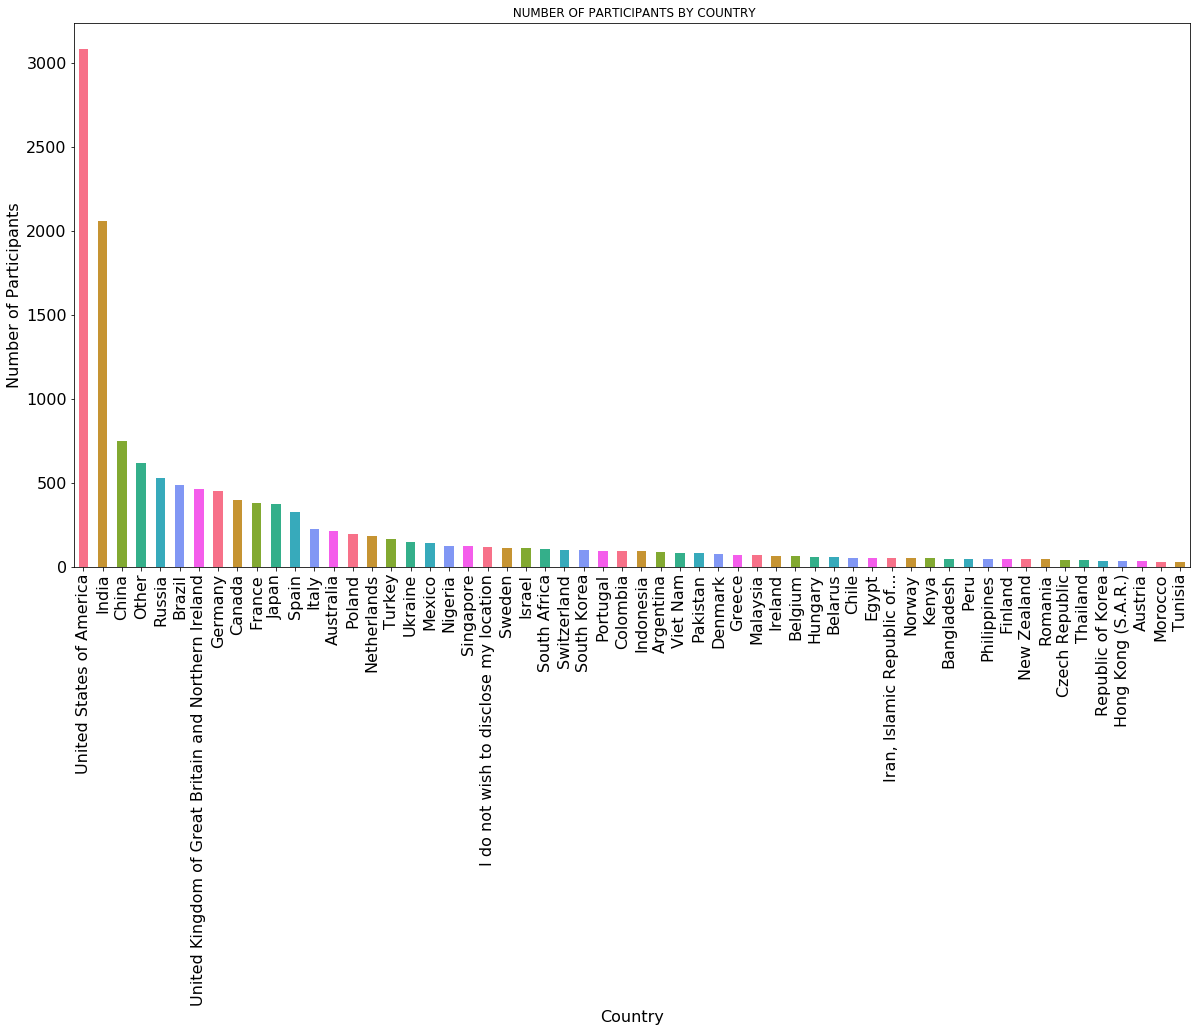

In [153]:
#Plotting the number of participants by country
colors=sns.color_palette("blue") 
pd.Series(data_analysis["Q3"]).value_counts().plot( kind = "bar",
                                                    color=colors,figsize=(20,10),fontsize=16,
                                                    rot=90,title=" NUMBER OF PARTICIPANTS BY COUNTRY")
plt.xlabel('Country', fontsize=16)
plt.ylabel('Number of Participants', fontsize=16)

The above figure shows the number of participants by country. There is an important difference among the 58 countries that are represented in this survey. The dominant countries are India and USA with more than 2000 and 3000 participants respectively Since the approach of this analysis is to find trends between deveolped and developing countries in the Data Science comunity, this fact will support the creation of two groups DEVELOPED COUNTRIES and DEVELOPING COUNTRIES very well represented by USA and India. India is a developing country and its number of participants will help to equate the number of participants in the USA and create a significant comparison of data. 

#### Compensation of Data Scientist 

Text(0.5, 1.0, 'Distribution of Yearly Compensation')

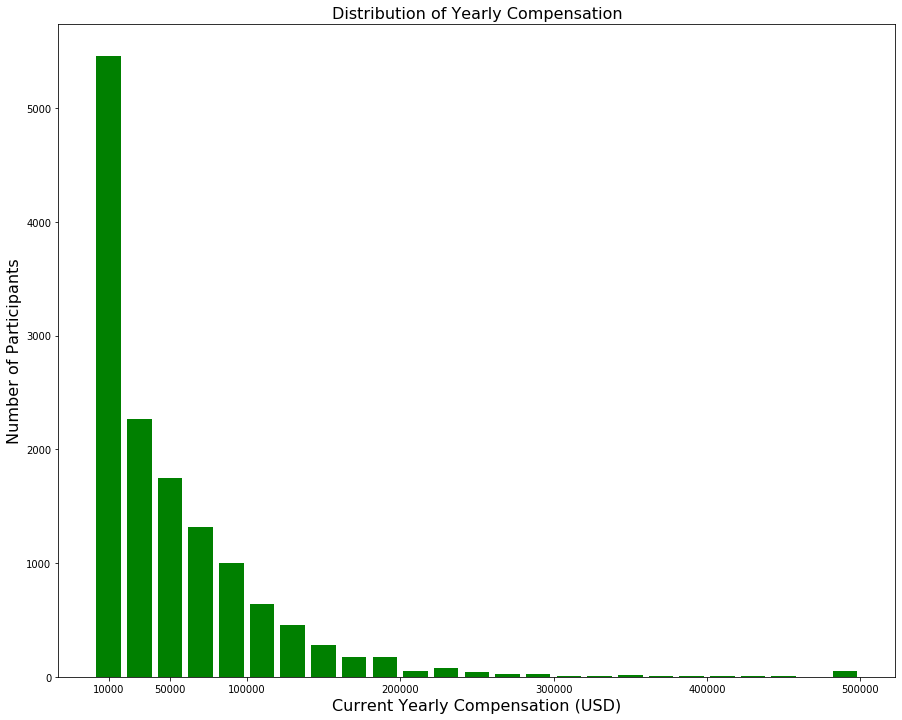

In [154]:
# Ploting a histogram of the distribution of year compensation by ranges
plt.figure(figsize=(15,12))
plt.hist(x='Q9',data=data_analysis,color="green",bins=25,rwidth=0.8)
plt.xticks([10000,50000,100000,200000,300000,400000,500000])
plt.xlabel('Current Yearly Compensation (USD)', fontsize=16)
plt.ylabel('Number of Participants', fontsize=16)
plt.title('Distribution of Yearly Compensation', fontsize=16)

The figure shows that approximately 80% of the population in this dataset earn up to 100,000 USD yearly and small percentage of the population earns roughly 500,000 USD. It is important to highlight that there is a pick of more that 5000 participants in the first bin that representes yearly compensation between 0 - 10000 USD. This peak could affect my prediction model by creating a bias for that reason I will do a futher analysis.

In [155]:
students=data_analysis[data_analysis['Q7'].isin(['I am a student'])]

Text(0.5, 1.0, 'Distribution of Yearly Compensation STUDENTS')

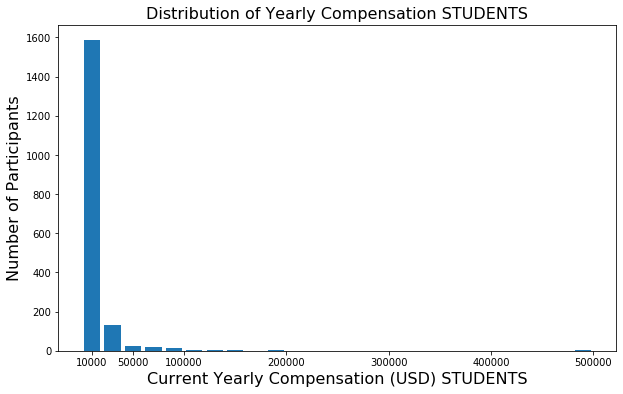

In [156]:
# Ploting a histogram of the distribution of students yearly compensation 
plt.figure(figsize=(10,6))
plt.hist(x='Q9',data=students,bins=25,rwidth=0.8)
plt.xticks([10000,50000,100000,200000,300000,400000,500000])
plt.xlabel('Current Yearly Compensation (USD) STUDENTS', fontsize=16)
plt.ylabel('Number of Participants', fontsize=16)
plt.title('Distribution of Yearly Compensation STUDENTS', fontsize=16)

About 1600 individuals out of 1797 participansts who are students earn between 0-10,000 USD yearly, This represents 90% of students that could create a bias in my model that I should consider during my model preparation.

### Trend - Impact of Formal Education on Compensation 

Text(0.5, 1.0, 'Impact of Formal Education on Compensation ')

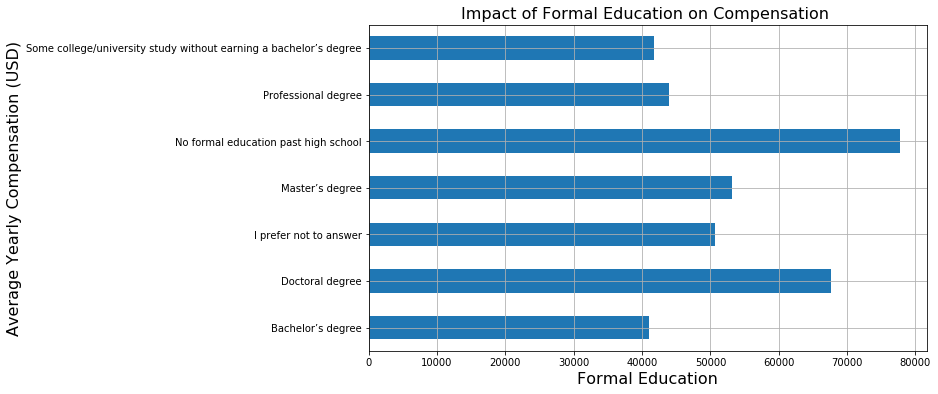

In [157]:
# Ploting Formal Education vs Average yearly compensation 
compensation = data_analysis.groupby('Q4').Q9.mean() #Group mean of compensation at Formal Education level
#Plot a bar chart figure to show trend
plt.figure(figsize=(10,6))
compensation.plot(kind='barh',grid=1)
plt.xlabel('Formal Education', fontsize=16) #X-axis label
plt.ylabel('Average Yearly Compensation (USD)', fontsize=16) #Chart title
plt.title('Impact of Formal Education on Compensation ', fontsize=16)
 

Surprisedly, the figure above shows that individuals with No Fomal Education past High School have the highest average yearly compensagtion (approx 79000 USD) follow by Doctoral and Master's degrees (approx 68000 and approx 53000 respectively). On the other side, individuals with a Bachelor's degree have the lowets avergae yearly compensation. Analysisng the dataset, I found that 101 participants declared No Fomal Education past High School and they have really high incomes due to years of experience. 

To eliminated possible errors during the cleaning steps, I want to plot the same figure but using the initial dataset to have an idea if the trend is the same as the figure above

Text(0.5, 1.0, 'Impact of Formal Education on Compensation ALL DATA ')

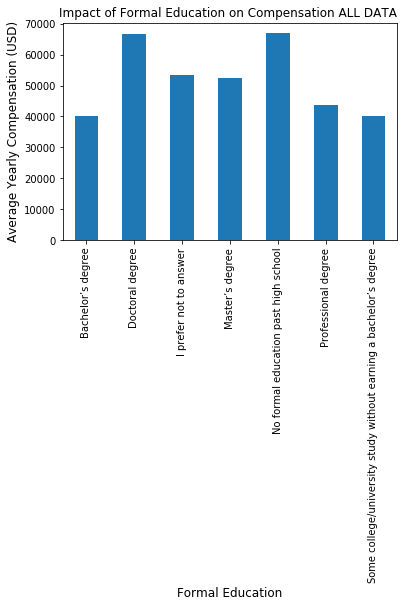

In [158]:
# Ploting Formal Education vs Average yearly compensation 
data_test=data_salary.copy()
#data_interval_encoding['Q46']=data_interval_encoding['Q46'].astype('category')
data_test['Q9']=data_test['Q9'].astype('int')
var = data_test.groupby('Q4').Q9.mean() #Group mean of compensation at Formal Education level
var.plot(kind='bar') 
plt.xlabel('Formal Education', fontsize=12) #X-axis label
plt.ylabel('Average Yearly Compensation (USD)', fontsize=12) #Chart title
plt.title('Impact of Formal Education on Compensation ALL DATA ', fontsize=12)

The above figure shows a trend in the complete dataset and it is very similar to the results discussed for the clean dataset.

### Average Compensation by Industry

Text(0.5, 1.0, 'Average Yearly Compensation by Industry')

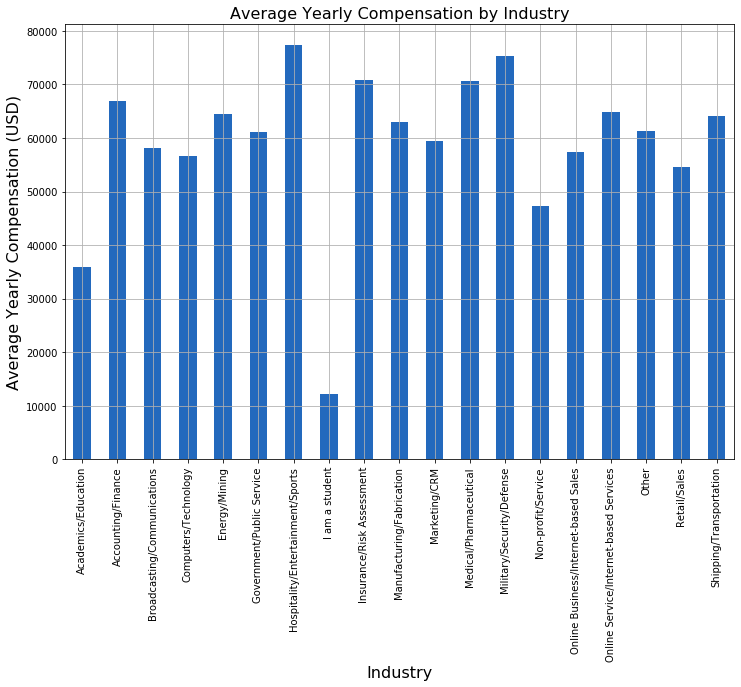

In [159]:
# Ploting Average yearly compensation by Industry
compensation = data_analysis.groupby('Q7').Q9.mean() #Group mean of compensation at Industry level
#Plot a bar chart figure to show trend
plt.figure(figsize=(12,8))
compensation.plot(kind='bar',grid=1,sort_columns=True,colormap='vlag')
plt.xlabel('Industry', fontsize=16) #X-axis label
plt.ylabel('Average Yearly Compensation (USD)', fontsize=16) #Chart title
plt.title('Average Yearly Compensation by Industry', fontsize=16)

The figure above shows the industries, and their average yearly compensation, compared to all others sectors. The top three industries with the highest average yearly compensation are Hospitally/Entretainment/Sports,Military/Security/Defense, Medical/Pharmaceutical, and Insurance/Risk Assesment with approximately the same average. On the other hand Academic and Non Profit/Service have the lowest average. I am student once again is a unique variable that is the lowest and confirm some of the insights found before. If we concentrate our efforts on some industry specific problems eventually get hired by them will be easier. 

### Impact of Years of Experience on Compensation

Text(0.5, 1.0, 'Average Yearly Compensation vs Experience')

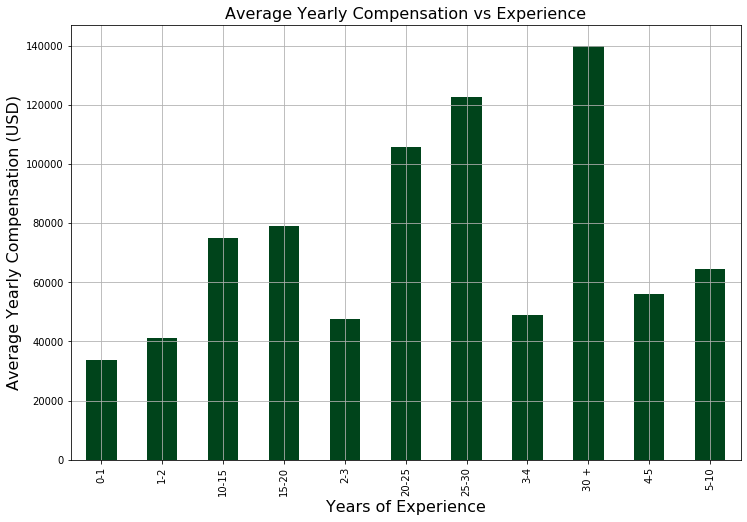

In [160]:
# Ploting Experience vs yearly compensation 
experience = data_analysis.groupby('Q8').Q9.mean() #Group mean of compensation at Industry level
#Plot a bar chart figure to show trend
plt.figure(figsize=(12,8))
experience.plot(kind='bar',grid=1,sort_columns=True,colormap='Greens_r')
plt.xlabel('Years of Experience', fontsize=16) #X-axis label
plt.ylabel('Average Yearly Compensation (USD)', fontsize=16) #Chart title
plt.title('Average Yearly Compensation vs Experience', fontsize=16)

As I mentioned before, individuals with more years of experience have an higher average yearly compensation. The difference bewteen 10-15 years of experience and 30+ is considerable significant. While in the early years of experience the difference is not that important until the breakdown appears at 5-10 years.

### Trend - Programming Language and Compensation

Text(0.5, 1.0, 'Average Yearly Compensation by Programming Language')

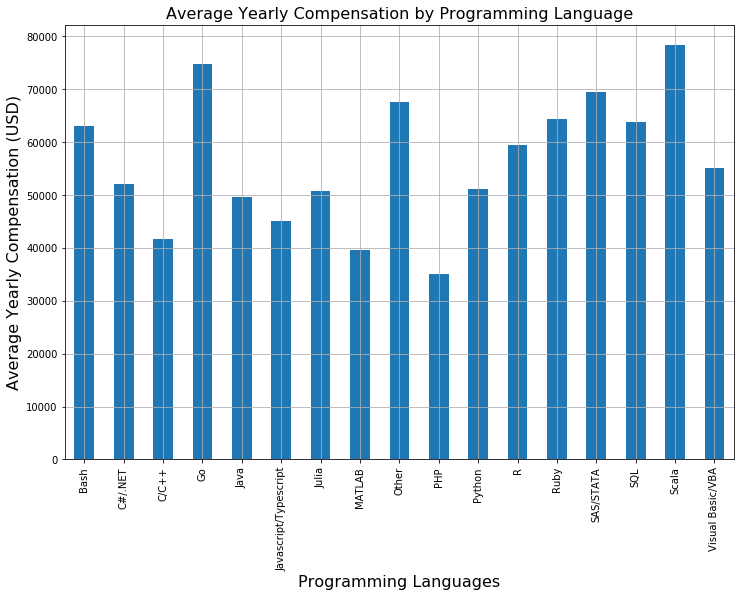

In [161]:
# Ploting Programming Language vs yearly compensation 
programming = data_analysis.groupby('Q17').Q9.mean() #Group mean of compensation at Programming Language level
#Plot a bar chart figure to show trend
plt.figure(figsize=(12,8))
programming.plot(kind='bar',grid=1,sort_columns=True)
plt.xlabel('Programming Languages', fontsize=16) #X-axis label
plt.ylabel('Average Yearly Compensation (USD)', fontsize=16) #Chart title
plt.title('Average Yearly Compensation by Programming Language', fontsize=16)

Individuals that use most often SCALA and Go programming languages have a highest yearly compensation while Python and R are whithin the top 10 programming Languages.Participants that use PHP and Matlab get the lowest average compenstion which is about 40000 USD


#### DATASET DEVELOPED AND DEVELOPING COUNTRIES
According to the Country Classification provides by the United Nation, WESP classifies all countries of the world into one of three broad categories: developed economies, economies in transition and developing economies. The composition of these groupings is intended to reflect basic economic country conditions. Several countries (in particular the economies in transition) have characteristics that could place them in more than one category; however, for purposes of analysis, the groupings have been made mutually exclusive. Based on that information I divided the 58 countries in two groups for my analysis.
DEVELOPED COUNTRIES and DEVELOPING COUNTRIES

#### DEVELOPED COUNTRIES

In [162]:
# Create the first group of countries DEVELOPED COUNTRIES
developed_countries=data_analysis.copy()
developed_countries=developed_countries[developed_countries['Q3'].isin(['United States of America','United Kingdom of Great Britain and Northern Ireland',
'Germany','Canada','France','Japan','Spain','Italy','Australia','Poland','Netherlands','Sweden','Switzerland','Portugal',
'Denmark','Greece','Belgium','Ireland','Hungary','Norway','Finland','New Zealand','Czech Republic','Romania','Austria'])]
developed_countries['Q9']=developed_countries['Q9'].astype('int')
developed_countries=developed_countries.reset_index(level=0, drop=True)

In [163]:
developed_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7187 entries, 0 to 7186
Columns: 360 entries, Q1 to Q50_Part_8
dtypes: int32(1), object(359)
memory usage: 19.7+ MB


Text(0.5, 1.0, 'Impact of Formal Education on Compensation Developed Countries ')

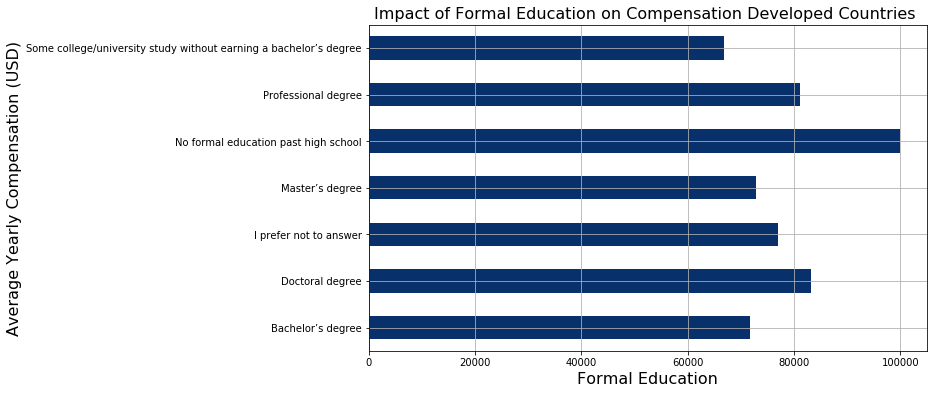

In [164]:
# Ploting Formal Education vs Average yearly compensation 
compensation = developed_countries.groupby('Q4').Q9.mean() #Group mean of compensation at Formal Education level
#Plot a bar chart figure to show trend
plt.figure(figsize=(10,6))
compensation.plot(kind='barh',grid=1,colormap='Blues_r')
plt.xlabel('Formal Education', fontsize=16) #X-axis label
plt.ylabel('Average Yearly Compensation (USD)', fontsize=16) #Chart title
plt.title('Impact of Formal Education on Compensation Developed Countries ', fontsize=16)

The trend for the develped countries sample wiht respect at Formal Education is similar to the trend for the complete dataset.No formal education past high school is still the highest, however; Professional and Doctoral Degree have almost the same average. Profesional Degrees are more common in Developed countries that in developing countries.

Text(0.5, 1.0, 'Average Yearly Compensation by Industry Developed Countries')

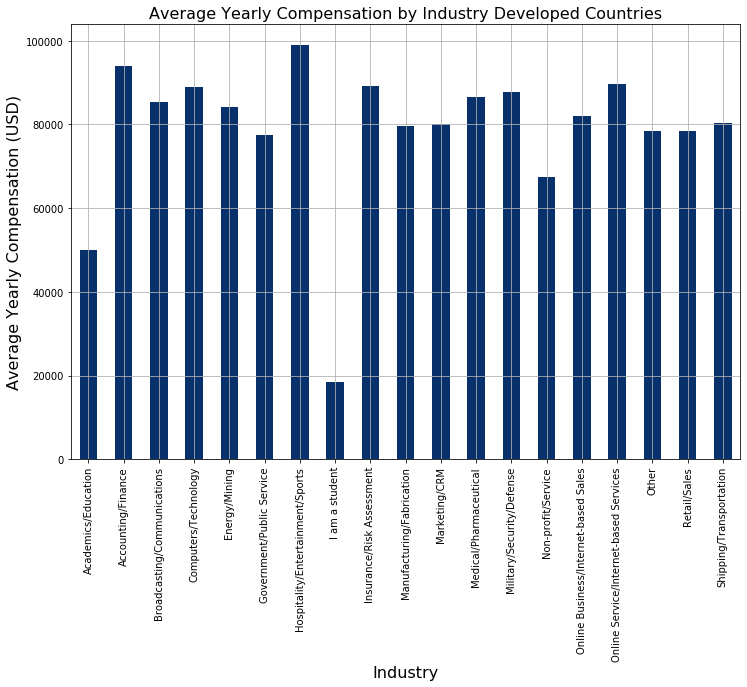

In [165]:
# Ploting Average yearly compensation by Industry
compensation = developed_countries.groupby('Q7').Q9.mean() #Group mean of compensation at Industry level
#Plot a bar chart figure to show trend
plt.figure(figsize=(12,8))
compensation.plot(kind='bar',grid=1,sort_columns=True,colormap='Blues_r')
plt.xlabel('Industry', fontsize=16) #X-axis label
plt.ylabel('Average Yearly Compensation (USD)', fontsize=16) #Chart title
plt.title('Average Yearly Compensation by Industry Developed Countries', fontsize=16)

The trend is similar to the complete dataset, but Accounting/Finance, Online Services , and Insurance have higher average. Military decrease the average compensation. This is am interesting insight since follow the industry trend of Developed Countries were Online Services, Medicine, Hospitality and Finance play an essential role.

Text(0.5, 1.0, 'Average Yearly Compensation by Programming Language Developed Countries')

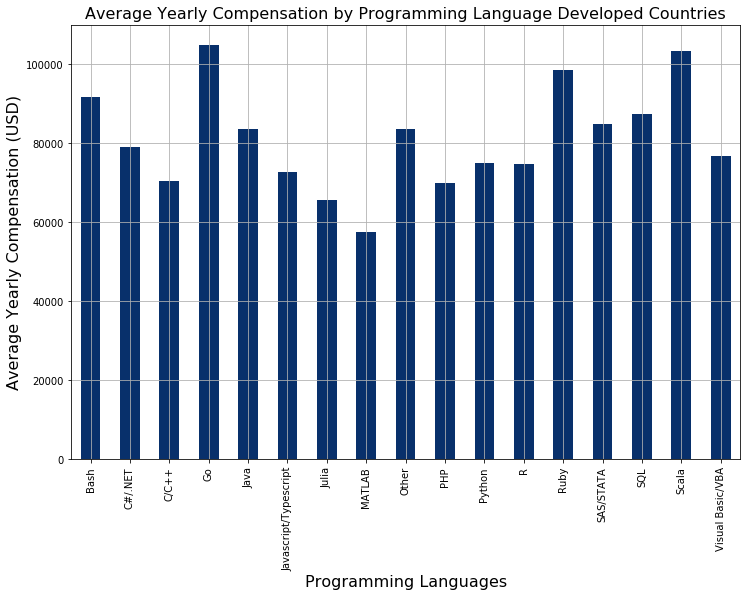

In [166]:
# Ploting Programming Language vs yearly compensation 
programming = developed_countries.groupby('Q17').Q9.mean() #Group mean of compensation at Programming Language level
#Plot a bar chart figure to show trend
plt.figure(figsize=(12,8))
programming.plot(kind='bar',grid=1,sort_columns=True,colormap='Blues_r')
plt.xlabel('Programming Languages', fontsize=16) #X-axis label
plt.ylabel('Average Yearly Compensation (USD)', fontsize=16) #Chart title
plt.title('Average Yearly Compensation by Programming Language Developed Countries', fontsize=16)

The trend is very similar GO ans SCALA are still predominant programming languages.

Text(0.5, 1.0, 'Average Yearly Compensation - Experience Developed Countries')

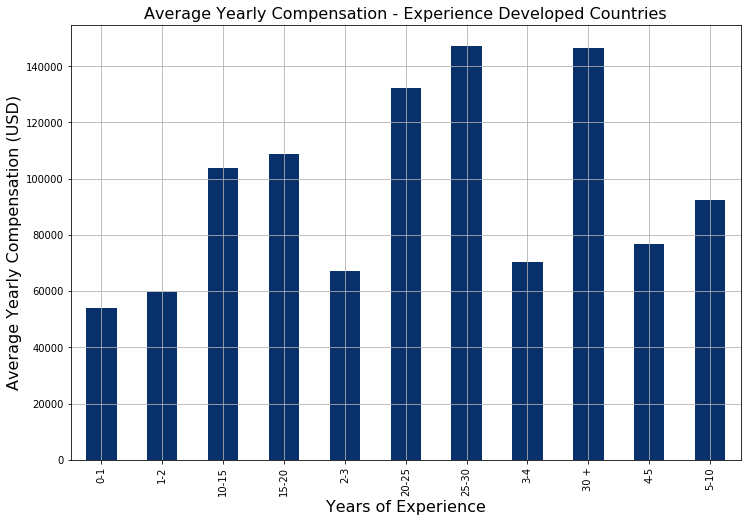

In [167]:
# Ploting Experience vs yearly compensation 
experience = developed_countries.groupby('Q8').Q9.mean() #Group mean of compensation at Industry level
#Plot a bar chart figure to show trend
plt.figure(figsize=(12,8))
experience.plot(kind='bar',grid=1,sort_columns=True,colormap='Blues_r')
plt.xlabel('Years of Experience', fontsize=16) #X-axis label
plt.ylabel('Average Yearly Compensation (USD)', fontsize=16) #Chart title
plt.title('Average Yearly Compensation - Experience Developed Countries', fontsize=16)

The above figure shows that there are a considerable number of "experts" in the field working in Developing countries with more than 15 years of experience. This idea makes sense since Developed countries were the firts places to use these methods and tools.

#### DEVELOPING COUNTRIES

In [168]:
# Create the second group of countries DEVELOPING COUNTRIES
developing_countries=data_analysis.copy()
developing_countries=developing_countries[developing_countries['Q3'].isin(['India','China','Other','Russia','Brazil','Turkey','Ukraine',
'Mexico','Nigeria','Singapore','I do not wish to disclose my location','Israel','South Africa','South Korea','Colombia',
'Indonesia','Argentina','Viet Nam','Pakistan','Malaysia','Belarus','Chile','Egypt','Iran, Islamic Republic of...',
'Kenya','Bangladesh','Philippines','Peru','Thailand','Republic of Korea','Hong Kong (S.A.R.)','Morocco','Tunisia'])]
developing_countries['Q9']=developing_countries['Q9'].astype('int')
developing_countries=developing_countries.reset_index(level=0, drop=True)

In [169]:
developing_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6670 entries, 0 to 6669
Columns: 360 entries, Q1 to Q50_Part_8
dtypes: int32(1), object(359)
memory usage: 18.3+ MB


Text(0.5, 1.0, 'Impact of Formal Education on Compensation Developing Countries ')

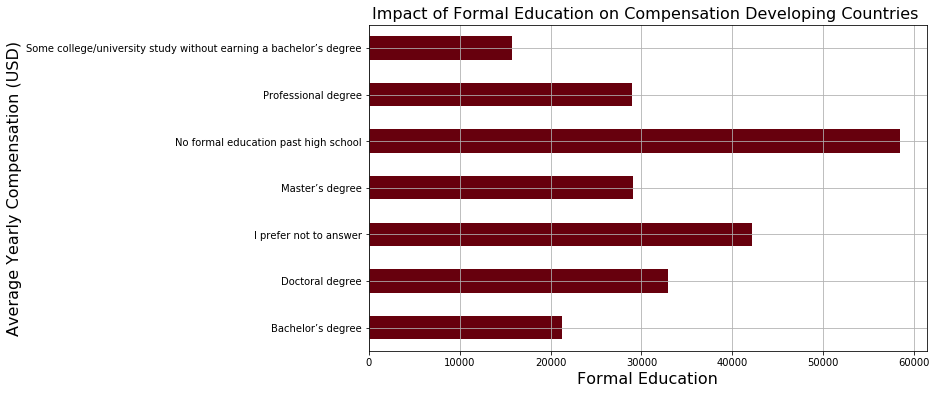

In [170]:
# Ploting Formal Education vs Average yearly compensation 
compensation = developing_countries.groupby('Q4').Q9.mean() #Group mean of compensation at Formal Education level
#Plot a bar chart figure to show trend
plt.figure(figsize=(10,6))
compensation.plot(kind='barh',grid=1,colormap='Reds_r')
plt.xlabel('Formal Education', fontsize=16) #X-axis label
plt.ylabel('Average Yearly Compensation (USD)', fontsize=16) #Chart title
plt.title('Impact of Formal Education on Compensation Developing Countries ', fontsize=16)

There is a very interesting insight, the difference between No formal Education past High School and the other categories is more prominent. Participants with a Doctoral or Master's degree decreased considerable while I prefer not to answer is a category with more importance. Moreover, the average yearly compensation decreases under 60000 USD compared to 100000 USD in developed countries

Text(0.5, 1.0, 'Average Yearly Compensation by Industry Developing Countries')

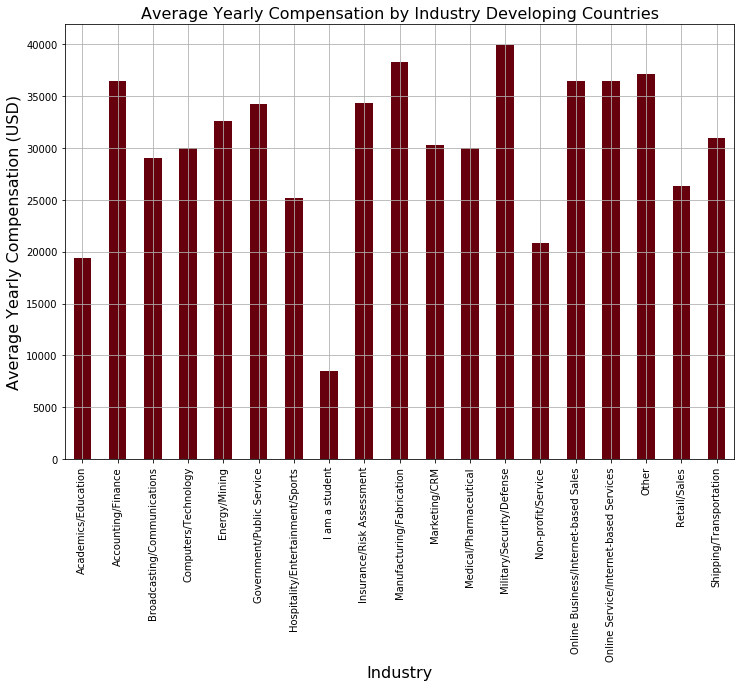

In [171]:
# Ploting Average yearly compensation by Industry
compensation = developing_countries.groupby('Q7').Q9.mean() #Group mean of compensation at Industry level
#Plot a bar chart figure to show trend
plt.figure(figsize=(12,8))
compensation.plot(kind='bar',grid=1,sort_columns=True,colormap='Reds_r')
plt.xlabel('Industry', fontsize=16) #X-axis label
plt.ylabel('Average Yearly Compensation (USD)', fontsize=16) #Chart title
plt.title('Average Yearly Compensation by Industry Developing Countries', fontsize=16)

Industries such as Military, Manufacturing, and Others become more important categories in these trend for developing countries. Entertainment decreases considerably its average, but Account/Finance, Goverment, and Energy/Mining maintain their averages. 

Text(0.5, 1.0, 'Average Yearly Compensation by Programming Language Developing Countries')

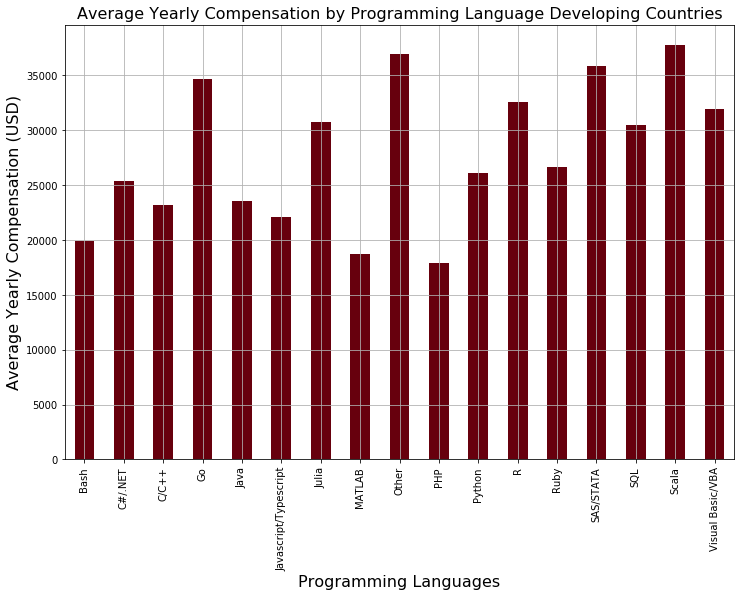

In [172]:
# Ploting Programming Language vs yearly compensation 
programming = developing_countries.groupby('Q17').Q9.mean() #Group mean of compensation at Programming Language level
#Plot a bar chart figure to show trend
plt.figure(figsize=(12,8))
programming.plot(kind='bar',grid=1,sort_columns=True,colormap='Reds_r')
plt.xlabel('Programming Languages', fontsize=16) #X-axis label
plt.ylabel('Average Yearly Compensation (USD)', fontsize=16) #Chart title
plt.title('Average Yearly Compensation by Programming Language Developing Countries', fontsize=16)

GO and SCALA are the top programming languages still, but Other and SAS/STATA have a higher importance for Developing countries 

Text(0.5, 1.0, 'Average Yearly Compensation - Experience Developing Countries')

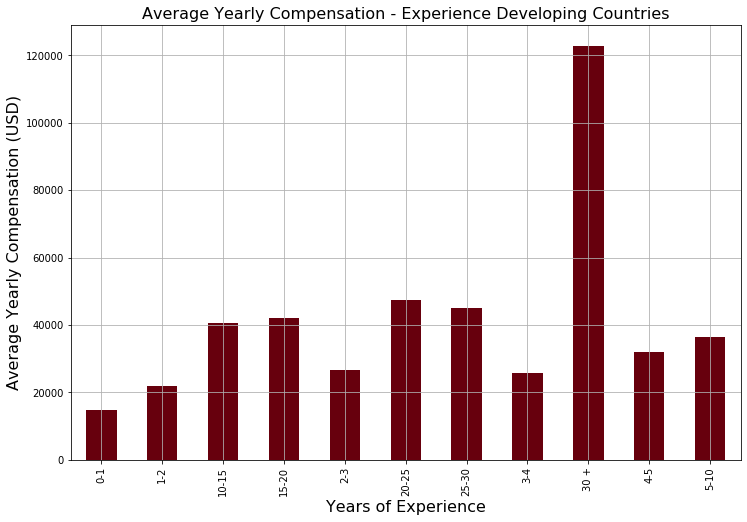

In [173]:
# Ploting Experience vs yearly compensation 
experience = developing_countries.groupby('Q8').Q9.mean() #Group mean of compensation at Industry level
#Plot a bar chart figure to show trend
plt.figure(figsize=(12,8))
experience.plot(kind='bar',grid=1,sort_columns=True,colormap='Reds_r')
plt.xlabel('Years of Experience', fontsize=16) #X-axis label
plt.ylabel('Average Yearly Compensation (USD)', fontsize=16) #Chart title
plt.title('Average Yearly Compensation - Experience Developing Countries', fontsize=16)

Avearge Compensation by years of experience drop down for Developing countries and the most of then are at 40000 USD per year. This is a big difference, that can be explained based on the ML as an emerging fiedl in developing countries.

One of the most important insights that I would like to mention is that the average yearly compensation decreases in developing countries as it is expected due to diffent economies. Manufacturing is a essential factor for developing countries while 'Consumption and Services' play a significant role for developed countries. 

### 2. Visualize the order of feature importance

Given the data, which of the original attributes in the data are most related to a survey respondent’s yearly compensation?

#### Correlation of Variables
In order to better understand the dataset, it is necessary to understand the problem and we will look at each variable and do an analysis about their meaning, its correlation with other variables, and importance for the yearly compensation varaible.

There are 50 questions or features and 1 target variable (yearly compensation). Searching for relationships between the features and the target is a recomendable step to identify which variables are correlated with the target and they might be useful to a model because they can be used to predict the target. 

In [174]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13756 entries, 0 to 13856
Columns: 196 entries, Q1 to Q40_5
dtypes: float64(19), int32(10), int64(1), uint8(166)
memory usage: 4.9 MB


In [175]:
dp_countries=data_clean.copy()
dp_countries=dp_countries[dp_countries['Q3'].isin(['56','55','16','7','15','27','48','26','1','40','32',
                                                   '49','50','41','12','17','5','24','19','35','14','13','11','43','2'])]
dp_countries=dp_countries.reset_index(level=0, drop=True)

In [176]:
ding_countries=data_clean.copy()
ding_countries=ding_countries[ding_countries['Q3'].isin(['21','9','36','44','6','53','54','30','34','45','20','25','46',
                        '47','10','22','0','57','37','29','4','8','23','3','28','33','39','38','42','51','18','52','31'])]
ding_countries=ding_countries.reset_index(level=0, drop=True)

In [177]:
dp_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7147 entries, 0 to 7146
Columns: 196 entries, Q1 to Q40_5
dtypes: float64(19), int32(10), int64(1), uint8(166)
memory usage: 2.5 MB


In [178]:
#My dataset has many columns and it is difficult to see the correlation of variables for that reason I divided this graph
# I fisrt selected 14 features.
variable1=dp_countries.loc[:,['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q23','Q24','Q25','Q26','Q32']]

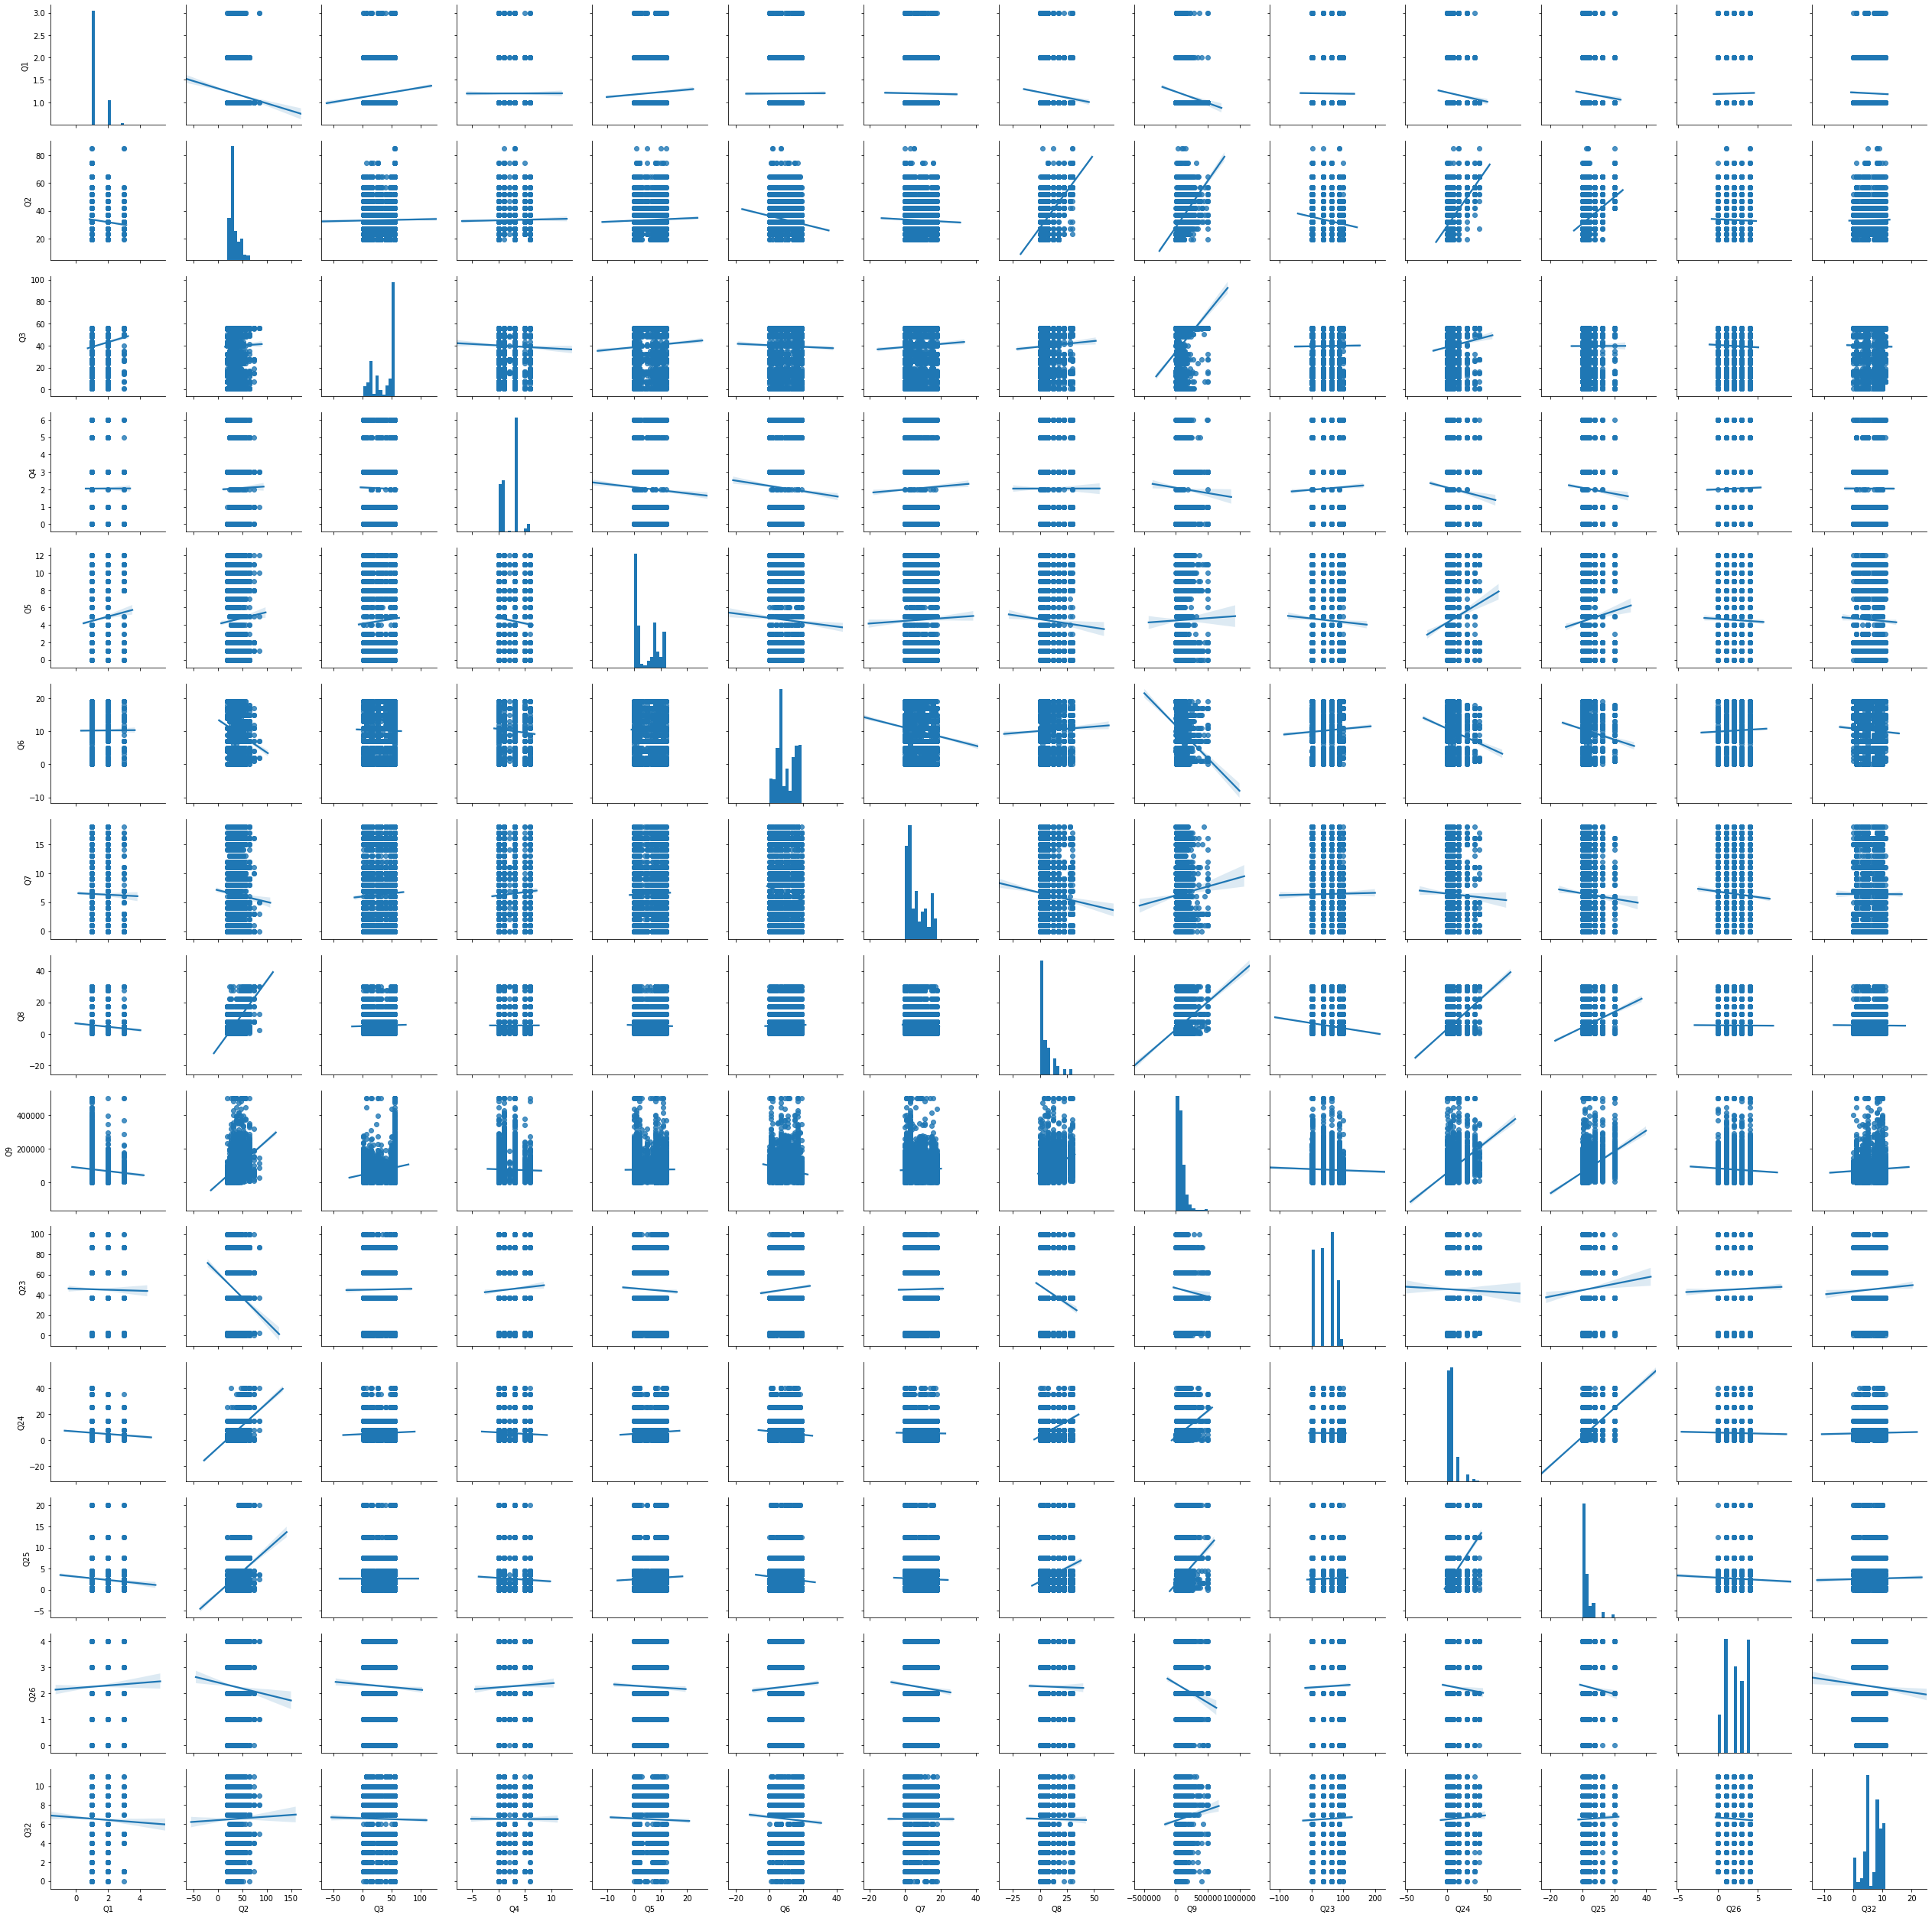

In [179]:
sns.pairplot(variable1, kind='reg')

The figure above shows the correlation of variables but it is difficult to identify relationships between features. Therefore I will show these correlation by parts. Since we have 50 questions, I will make the analysis of feature importance taking groups of features (columns)

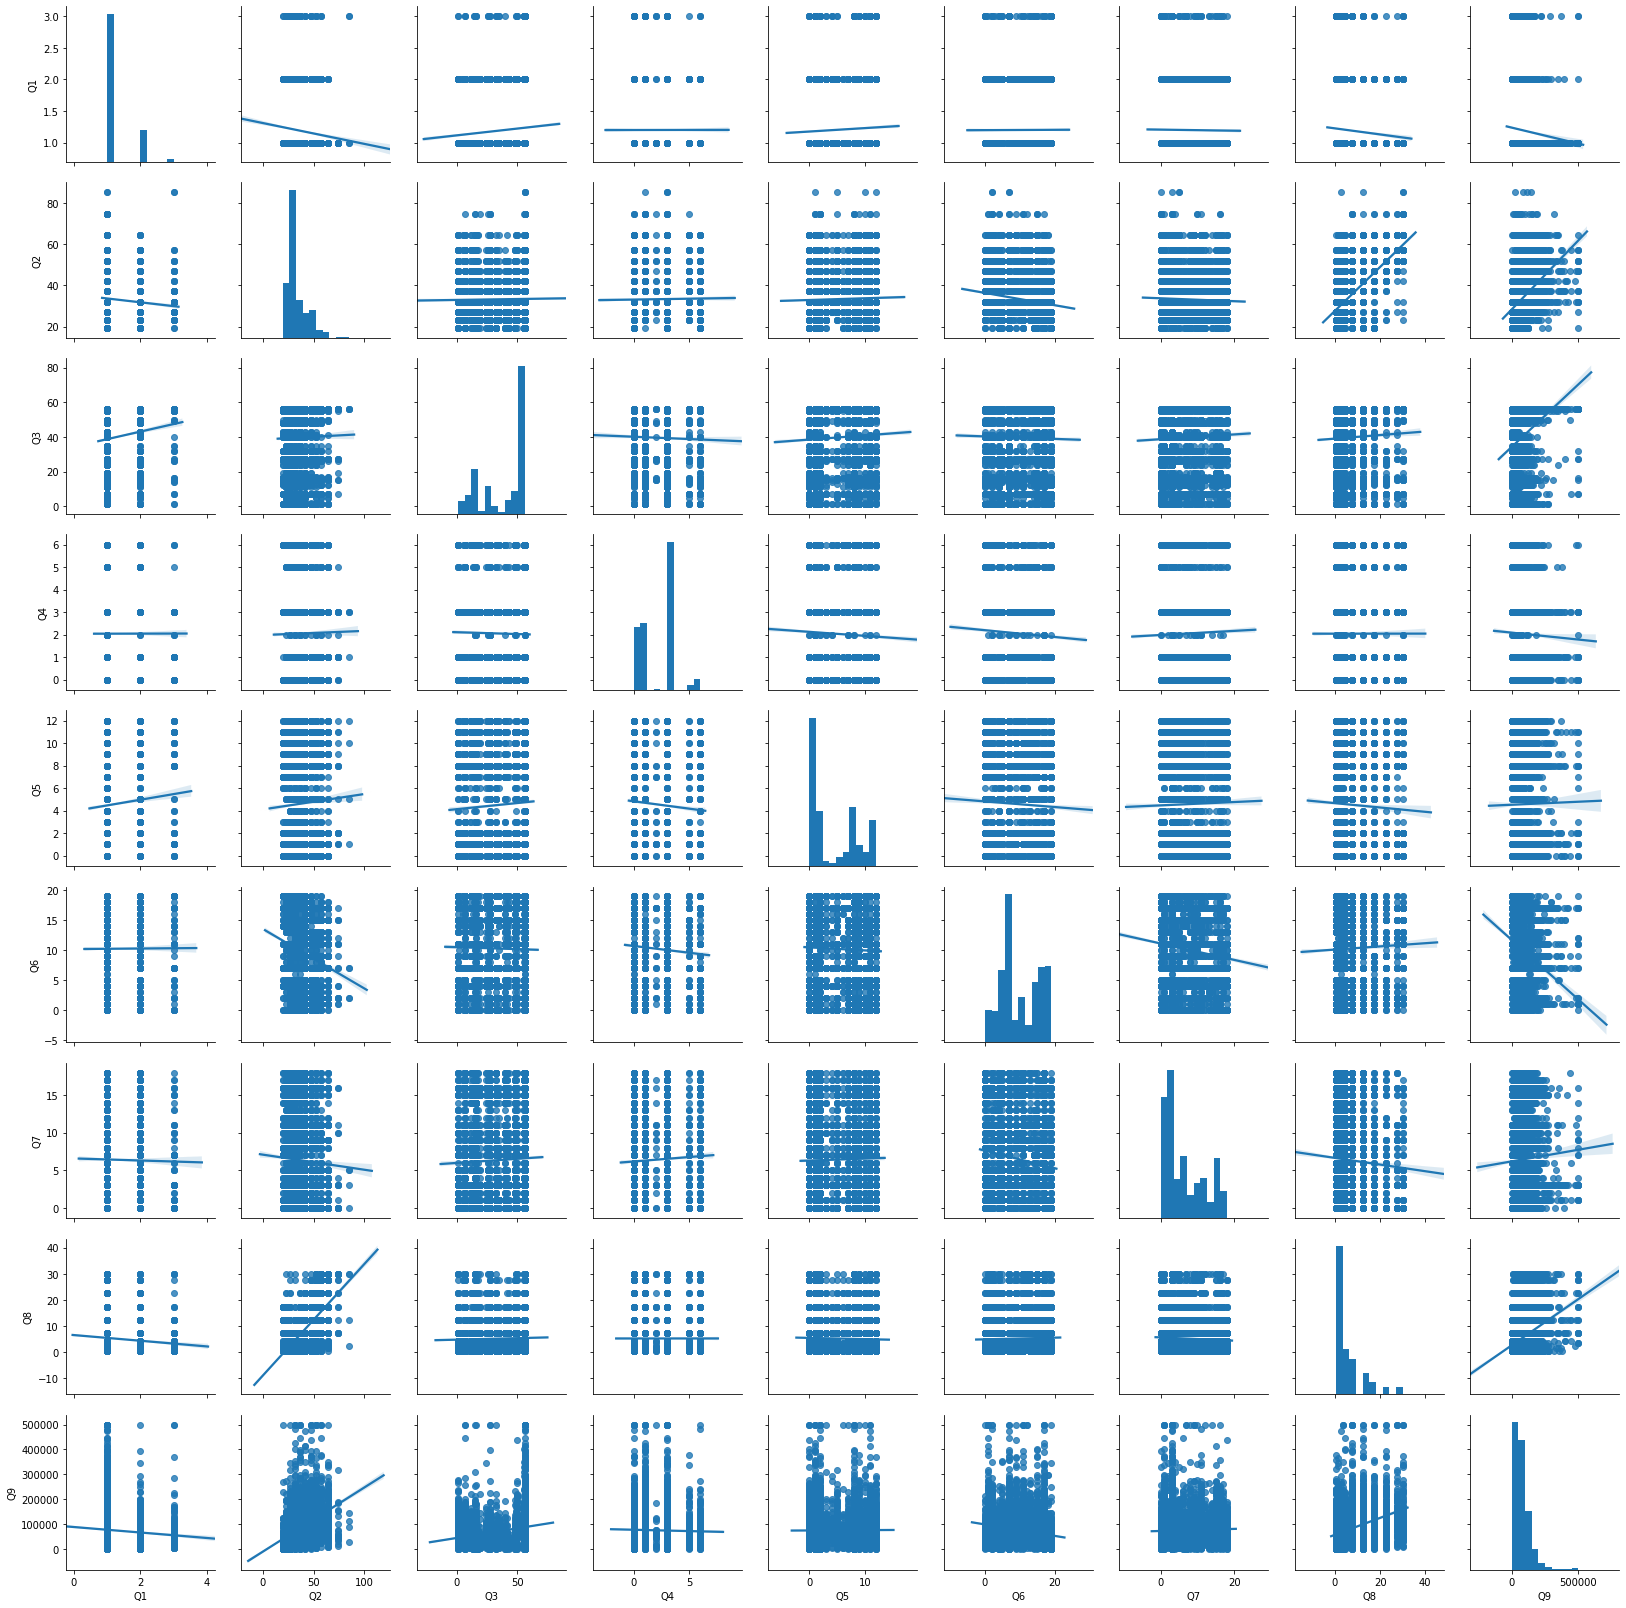

In [180]:
variable2=dp_countries.loc[:,['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9']]
sns.pairplot(variable2, kind='reg')

columns=['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q23','Q24','Q25',
        'Q26','Q32','Q34_Part_1','Q34_Part_2','Q34_Part_3','Q34_Part_4',
        'Q34_Part_5','Q34_Part_6','Q35_Part_1','Q35_Part_2','Q35_Part_3',
        'Q35_Part_4','Q35_Part_5','Q35_Part_6','Q37','Q43','Q46','Q48']
sns.pairplot(variable_importance[columns],hue="Q9")

# 3. FEATURE SELECTION (MODEL PREPARATION)

Explain how feature engineering is a useful tool in machine learning.

Feature engineering is considered the process of creating new features from the dataset that make machine learning algorithms work efficiently. The creation of new features is based on the knowledge of the data, correlation, and importance of the features. If feature engineering is done “correctly”, it increases the predictive power of machine learning algorithms. By creating features from raw data that help facilitate the machine learning process. These new  features migh better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

Some of the techniques of feature engineering help to reduce the number of features by creating new variables that explain better the data. For instance, in the cleaning data section I used feature engineering to reduce the number of features. For instance, I reduced from 48 features (columns) to 8 features by creating groups.

Dimensionality and overfitting are aspects that Feature Engineering has impact on, Dimensionality is just the number of columns in the dataset, but it has significant downstream effects on the eventual models.  At the extremes, the concept of the “curse of dimensionality” discusses that in high-dimensional spaces some things just stop working properly. 
Even in relatively low dimensional problems, a dataset with more dimensions requires more parameters for the model to understand, and that means more rows to reliably learn those parameters. If the number of rows in the dataset is fixed, addition of extra dimensions without adding more information for the models to learn from can have a detrimental effect on the eventual model accuracy.


### Feature Selection 

For the feature selection process, I used manual selection analysis first and second I applied a feature selection algorithm.

#### Manual selection analysis
The clean dataset has 196 columns (reduced from 390 initial columns). As I mention, during the data cleaning, I took advange of some of the steps in order to start applying feature engineering. For example

1. Q1. Gender, reduction of features by creating three gropus instead of 4 intial grops.

2. Q27, Q28, Q29, Q30 features were grouped to reduce the number of features. This step will not affect the final anlaysis since data was not lose. Specific information such as Google Cloud ML was grouped as Google losing some details that will not affect the final result.

3. Q16, Q19, Q21, Q31,Q36 were dropped since the information was repeated in Q17, Q20, Q22, Q32, Q37 respectively.

4. Q33, Q38, Q39, Q41, Q42, Q44, Q45, Q47, Q49, and Q50 were dropped becasued these question present OPINION that do not add any valuable information for the prediction model.

Additionally, after the feature importance step some variables are dropped since do not present an valuable importance for the prediction model such as Gender. All the entries "I am student" are deleted since these values create a bias as was presented in tha EDA above. Q48 Do you consider ML models to be "black boxes" with outputs that are difficult or impossible to explain? Q46 Approximately what percent of your data projects involve exploring model insights? do not have a strong correlation with the target varaible. 

#### NOTE

By using manual analysis selection based on the my EDA and the idea of comparing Developed and Developing Countries I have decided selecte the folowing features:

Q2	What is your age (# years)?					
Q3	In which country do you currently reside?					
Q4	What is the highest level of formal education that you have attained or plan to attain within the next 2 years?				
##Q5	Which best describes your undergraduate major?				
Q6	Select the title most similar to your current role (or most recent title if retired)					
Q7	In what industry is your current employer/contract (or your most recent employer if retired)?			
Q8	How many years of experience do you have in your current role?

Q17  What specific programming language do you use most often?

Q18 What programming language would you recommend an aspiring data scientist to learn first? 

Q25 For how many years have you used machine learning methods (at work or in school)?

Q35 What percentage of your current machine learning/data science training falls under each category?


In [181]:
feature_selection=dp_countries.copy()
feature_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7147 entries, 0 to 7146
Columns: 196 entries, Q1 to Q40_5
dtypes: float64(19), int32(10), int64(1), uint8(166)
memory usage: 2.5 MB


In [182]:
feature_selection= feature_selection.drop(columns=['Q1','Q48','Q46', 'Q5'])
feature_selection =feature_selection[feature_selection.Q7 != 7]
feature_selection=feature_selection.reset_index(level=0, drop=True)
feature_selection.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6464 entries, 0 to 6463
Columns: 192 entries, Q2 to Q40_5
dtypes: float64(18), int32(8), uint8(166)
memory usage: 2.1 MB


#### Feature selection algorithm

After selecting 11 features by manual analysis technique, I will use a feture selection algorithm to select the most important of the remianing features in the dataset.
1. First, I will use RFE Recursive Feature Elimination that works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.
2. Lasso regression that is based on the reduction of the cost function. This type of regularization (L1) can lead to zero coefficients. Some of the features are completely neglected for the evaluation of output. Lasso regression not only helps in reducing over-fitting but it help with feature selection. 

In [183]:
# Feature Extraction with RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
# Defining x variable features.
# I dropped the target Q9 and the other features that selectedt in the sections above.
X = feature_selection.drop(['Q9','Q2','Q3','Q4','Q6','Q7','Q8','Q35_Part_1',
'Q35_Part_2','Q35_Part_3','Q35_Part_4','Q35_Part_5','Q35_Part_6','Q17_Bash','Q17_C#/.NET','Q17_C/C++','Q17_Go',
'Q17_Java','Q17_Javascript/Typescript','Q17_Julia','Q17_MATLAB','Q17_Other','Q17_PHP','Q17_Python','Q17_R','Q17_Ruby',
'Q17_SAS/STATA','Q17_SQL','Q17_Scala','Q17_Visual Basic/VBA','Q18_C++','Q18_Go','Q18_Java','Q18_Javascript',
'Q18_MATLAB','Q18_None','Q18_Other','Q18_Python','Q18_R','Q18_SAS','Q18_SQL','Q18_Scala','Q18_VBA','Q25'],axis=1)

y = feature_selection['Q9']

# feature extraction
model = LinearRegression()
rfe = RFE(model, 20)
fit = rfe.fit(X, y)

#print("x:%d, prime YES" % (x,))
print("Num Features: %d" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 20
Selected Features: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False  True False False]
Feature Ranking: [127  94 117 122  46  64  48  82  70 121 123 

Using RFE algorith, it selected 20 features out of 148. The features selected are label as True in the matrix "Selected Features" that was printed above.

In [184]:
# Using Lasso Regression

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
# Defining x variable features.
# I dropped the target Q9 and the other features that selectedt in the sections above.
X = feature_selection.drop(['Q9','Q2','Q3','Q4','Q6','Q7','Q8','Q35_Part_1',
'Q35_Part_2','Q35_Part_3','Q35_Part_4','Q35_Part_5','Q35_Part_6','Q17_Bash','Q17_C#/.NET','Q17_C/C++','Q17_Go',
'Q17_Java','Q17_Javascript/Typescript','Q17_Julia','Q17_MATLAB','Q17_Other','Q17_PHP','Q17_Python','Q17_R','Q17_Ruby',
'Q17_SAS/STATA','Q17_SQL','Q17_Scala','Q17_Visual Basic/VBA','Q18_C++','Q18_Go','Q18_Java','Q18_Javascript',
'Q18_MATLAB','Q18_None','Q18_Other','Q18_Python','Q18_R','Q18_SAS','Q18_SQL','Q18_Scala','Q18_VBA','Q25'],axis=1)

# NOTE: In the beginning I ran the Lasso regression including all the features even those features that were selected manually
# in order to verify that those features have an important weight to predict the target variable
# The result was very similar, and lasso regression select 'Q2','Q3','Q4','Q5','Q6','Q7','Q8' as features.

#X = feature_selection.drop(['Q9'],axis=1)
y = feature_selection['Q9']


# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV(cv=5)

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.25)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

# Reset the threshold till the number of features equals 20.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features > 20:
    sfm.threshold += 0.1
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

In [185]:
# Defining fetures selected by the model
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1]
feature3 = X_transform[:, 2]
feature4 = X_transform[:, 3]
feature5 = X_transform[:, 4]
feature6 = X_transform[:, 5]
feature7 = X_transform[:, 6]
feature8 = X_transform[:, 7]
feature9 = X_transform[:, 8]
feature10 = X_transform[:, 9]
feature11 = X_transform[:, 10]
feature12 = X_transform[:, 11]
feature13 = X_transform[:, 12]
feature14 = X_transform[:, 13]
feature15 = X_transform[:, 14]
feature16 = X_transform[:, 15]
feature17 = X_transform[:, 16]
feature18 = X_transform[:, 17]
feature19 = X_transform[:, 18]
feature20 = X_transform[:, 19]

feature21 = X_transform[:, 20]
feature22 = X_transform[:, 21]
feature23 = X_transform[:, 22]
feature24 = X_transform[:, 23]
feature25 = X_transform[:, 24]
feature26 = X_transform[:, 25]
feature27 = X_transform[:, 27]
feature28 = X_transform[:, 28]
feature29 = X_transform[:, 29]
feature30 = X_transform[:, 30]
feature31 = X_transform[:, 31]
feature32 = X_transform[:, 32]
feature33 = X_transform[:, 33]
feature34 = X_transform[:, 34]
feature35 = X_transform[:, 35]
feature36 = X_transform[:, 36]
feature37 = X_transform[:, 37]
feature38 = X_transform[:, 38]
feature39 = X_transform[:, 39]
feature40 = X_transform[:, 40]

# 4. MODEL IMPLEMENTATION

Implement 4 different regression/prediction algorithms of your choice on the training
data using 10-fold cross-validation. How does your model accuracy compare across the
folds? What is average and variance of accuracy for folds? Which model performed best?
Give the reason based on bias-variance trade-off. For each algorithm, briefly talk about
what it does, what its pros and cons are, and why you chose that algorithm.

In [187]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer, r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score, cross_val_predict

In [188]:
# Create a copy of the final feature selection dataset
model_preparation=feature_selection.copy()

In [189]:
#Final feature preparation
#Droping variables after Random Forest Variable importance results to get a better performance of the models
model_preparation = pd.get_dummies(model_preparation, columns=['Q2'], prefix= ['Q2'])
model_preparation = pd.get_dummies(model_preparation, columns=['Q4'], prefix= ['Q4'])
model_preparation = pd.get_dummies(model_preparation, columns=['Q3'], prefix= ['Q3'])
model_preparation = pd.get_dummies(model_preparation, columns=['Q6'], prefix= ['Q6'])
model_preparation = pd.get_dummies(model_preparation, columns=['Q7'], prefix= ['Q7'])
model_preparation = pd.get_dummies(model_preparation, columns=['Q8'], prefix= ['Q8'])
model_preparation = model_preparation.drop(['Q23','Q25','Q32','Q37','Q43'],axis=1)
model_preparation = pd.get_dummies(model_preparation, columns=['Q26'], prefix= ['Q26'])
model_preparation = model_preparation.drop(['Q34_Part_1','Q34_Part_2','Q34_Part_3','Q34_Part_4','Q34_Part_5','Q34_Part_6'],axis=1)
model_preparation = model_preparation.drop(['Q35_Part_1','Q35_Part_2','Q35_Part_3','Q35_Part_4','Q35_Part_5','Q35_Part_6'],axis=1)
model_preparation = model_preparation.drop(['Q14_Kaggle Kernels','Q14_Google Colab','Q14_Azure Notebook','Q14_Domino Datalab',
                                            'Q14_Google Cloud Datalab','Q14_Paperspace','Q14_Floydhub','Q14_Crestle','Q14_JupyterHub/Binder',
                                            'Q14_None','Q14_Other'],axis=1)

In [190]:
model_preparation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6464 entries, 0 to 6463
Columns: 254 entries, Q9 to Q26_4
dtypes: float64(1), int32(1), uint8(252)
memory usage: 1.6 MB


### ---------------------------------------------------------------------------------------------------------------------------------------------

This small section has the multiple feature selection that I did to get to these finak feature selection

In [240]:
features=feature_selection.loc[:,['Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q35_Part_1',
'Q35_Part_2','Q35_Part_3','Q35_Part_4','Q35_Part_5','Q35_Part_6','Q17_Bash','Q17_C#/.NET','Q17_C/C++','Q17_Go',
'Q17_Java','Q17_Javascript/Typescript','Q17_Julia','Q17_MATLAB','Q17_Other','Q17_PHP','Q17_Python','Q17_R','Q17_Ruby',
'Q17_SAS/STATA','Q17_SQL','Q17_Scala','Q17_Visual Basic/VBA','Q18_C++','Q18_Go','Q18_Java','Q18_Javascript',
'Q18_MATLAB','Q18_None','Q18_Other','Q18_Python','Q18_R','Q18_SAS','Q18_SQL','Q18_Scala','Q18_VBA','Q25']]

In [229]:
features1=feature_selection.loc[:,['Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q35_Part_1',
'Q35_Part_2','Q35_Part_3','Q35_Part_4','Q35_Part_5','Q35_Part_6','Q17_Bash','Q17_C#/.NET','Q17_C/C++','Q17_Go',
'Q17_Java','Q17_Javascript/Typescript','Q17_Julia','Q17_MATLAB','Q17_Other','Q17_PHP','Q17_Python','Q17_R','Q17_Ruby',
'Q17_SAS/STATA','Q17_SQL','Q17_Scala','Q17_Visual Basic/VBA','Q18_C++','Q18_Go','Q18_Java','Q18_Javascript',
'Q18_MATLAB','Q18_None','Q18_Other','Q18_Python','Q18_R','Q18_SAS','Q18_SQL','Q18_Scala','Q18_VBA','Q25']]

##### Adding features selected to features dataframe
features['F1']=feature1
features['F3']=feature2
features['F3']=feature3 
features['F4']=feature4 
features['F5']=feature5
features['F6']=feature6 
features['F7']=feature7
features['F8']=feature8 
features['F9']=feature9 
features['F10']=feature10 
features['F11']=feature11
features['F12']=feature12
features['F13']=feature13
features['F14']=feature14
features['F15']=feature15
features['F16']=feature16
features['F17']=feature17
features['F18']=feature18
features['F19']=feature19 
features['F20']=feature20

### ----------------------------------------------------------------------------------------------------------------------------------------------------------

In [191]:
# Definition of the formula for cross validation training set

def run_kfold_train(model,features,target):
    
    X =features
    Y =target
    
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes1 = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_train)
        
        accuracy1 = r2_score(Y_train, predictions) 
        outcomes1.append(accuracy1)
        print("Fold {0} accuracy: {1}".format(fold, accuracy1))   
        
    mean_outcome = np.mean(outcomes1)
    std_outcome=np.std(outcomes1)
    print("Mean r2 Training: {0}".format(mean_outcome)) 
    print("Standard Deviation Training: {0}".format(std_outcome)) 
    
    return (outcomes1)

In [192]:
# Definition of the formula for cross validation test set
# I need to run these cross validation in both dataset to get the data to plor the graph error vs cross validation and show
#bias-variance tradeoff

def run_kfold_test(model,features,target):
    
    X =features
    Y =target
    
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes2 = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy2 = r2_score(Y_test, predictions)
        outcomes2.append(accuracy2)
        print("Fold {0} accuracy: {1}".format(fold, accuracy2))   
        
    mean_outcome = np.mean(outcomes2)
    std_outcome=np.std(outcomes2)
    print("Mean r2 Test: {0}".format(mean_outcome)) 
    print("Standard Deviation Test: {0}".format(std_outcome)) 
    
    return (outcomes2)

In [193]:
#Defining features and one target value.
X=model_preparation.drop(['Q9'],axis=1)
y=model_preparation['Q9']

In [194]:
#Split the data into training data (70%) and test data (30%)
# I am not using validation set since I will use crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=101)

### Linear Regression

Linear regression is a type of regression analysis where the number of independent variables has a linear relationship between the independent(x) and dependent(y) variables. The model has the form y = B0 + B1 X1 + B2 X2 + ... + Bn Xn. This model to find the best fit straight line or polynomial regression. The cost function MSE helps us to figure out the best possible values for B0, B1, ..., Bn which would provide the best fit model for the data points. Since we want the best parameter B, we convert this search problem into a minimization problem where we would like to minimize the error between the predicted value and the actual value.

PROS

Linear regression is used as baseline prediction model specially for Econometric predictions and Modelling marketing responses	
It is simple to understand and explain
Linear regression models occasionally overfits
Using L1 & L2 regularization is effective in feature selection
Fast to train and it is particularly useful when the relationship to be modeled is not complex
It can work very well even if there is not a lot of data but it is also easy to train on big data thanks to its stochastic version	

CONS

For non-linear data (polynomial regression) is hard to make fit nonlinear functions. Therefore, it is not that good with highly complex data
This model can suffer from outliers

I decided to try this model first to have a baseline predction of the data and how it will work on the test. It is always recomendable to try the simple model first to have an initial idea. Moreover, this dataset has a considerable number of features and computational time is important. I try this model with the complete dataset and with my subset Developed Countries and the accuracy of the model was very similar.

In [195]:
#Defining features and one target value.
#X = data.drop(['Sound Pressure Level'], axis=1)
X=model_preparation.drop(['Q9'],axis=1)
y=model_preparation['Q9']

In [196]:
#Split the data into training data (70%) and test data (30%)
# I am not using validation set since I will use cross-validation
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=101)

In [197]:
# Implementation of model using training set
lm=LinearRegression()
clf = lm.fit(X_train, y_train) # applying model
clf

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [198]:
# Returns the coefficient of determination R^2 of the prediction.
lm.score(X_train, y_train)

0.5581328321315246

#### 10 folds Cross Validation

In [199]:
training_error=run_kfold_train(lm,X,y)

Fold 1 accuracy: 0.5381260502355258
Fold 2 accuracy: 0.5418378505100108
Fold 3 accuracy: 0.5429136803528594
Fold 4 accuracy: 0.5400945570603444
Fold 5 accuracy: 0.5419278127815548
Fold 6 accuracy: 0.5373718700736689
Fold 7 accuracy: 0.5445193919430631
Fold 8 accuracy: 0.5379816670622541
Fold 9 accuracy: 0.5492350913052018
Fold 10 accuracy: 0.5413696714701304
Mean r2 Training: 0.5415377642794614
Standard Deviation Training: 0.0033767688464842417


In [200]:
test_error=run_kfold_test(lm,X,y)

Fold 1 accuracy: 0.4981273146241548
Fold 2 accuracy: 0.47269715150876124
Fold 3 accuracy: 0.46341499100595773
Fold 4 accuracy: 0.4757392514884906
Fold 5 accuracy: 0.4778403869571981
Fold 6 accuracy: 0.5336889238648572
Fold 7 accuracy: 0.4587476795099802
Fold 8 accuracy: 0.5251636939573437
Fold 9 accuracy: 0.40850210674701504
Fold 10 accuracy: 0.43752967970102685
Mean r2 Test: 0.47514511793647857
Standard Deviation Test: 0.035684325035692716


(0.05, 0.7)

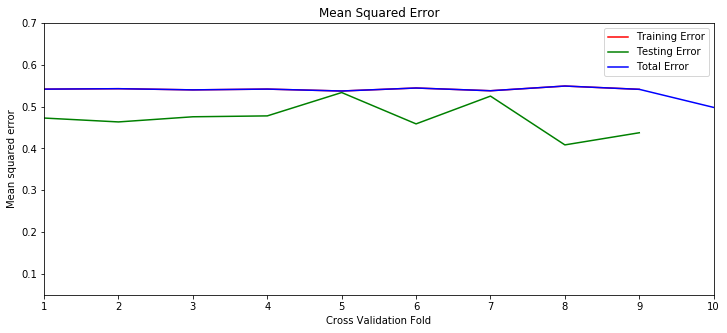

In [201]:
# Plot bias vs variance from changing the depth of the tree
plt.figure(figsize=(12,5))
plt.plot(training_error,'r',label='Training Error')
plt.plot(test_error,'g',label='Testing Error')
plt.plot(training_error + test_error, 'b', label='Total Error')
plt.title("Mean Squared Error")
plt.xlabel("Cross Validation Fold")
plt.ylabel("Mean squared error")
plt.legend(loc=1)
plt.xlim(1,10)
plt.ylim(0.05, 0.7)

Text(0, 0.5, 'Mean squared error Training')

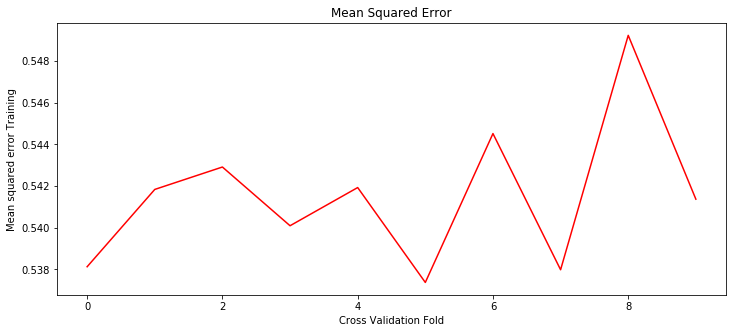

In [202]:
plt.figure(figsize=(12,5))
plt.plot(training_error,'r',label='Training Error')
plt.title("Mean Squared Error")
plt.xlabel("Cross Validation Fold")
plt.ylabel("Mean squared error Training")

### Random Forest

Random Fores model is an ensemble of decision trees. The input vector is run through multiple decision trees. For regression, the output value of all the trees is averaged while for classification a voting scheme is used to determine the final class.
A decision trees model passes the input down the branches of the tree and selects the next branch to go down based on a decision at a node. Random Forest is a flexible algorithm, easy to code and widely use in machine learning. It can be used for both classification and regression tasks. 

PROS
Random Fores it is applied at almost any machine learning problem with great outcomes
It is great at learning complex non-linear relationships achieving hihg performance even better than polynomila regression
It can work in parallel and occasionally overfits
Automatically handles missing values
No need to transform any variable
No need to tweak parameters
Can be used by almost anyone with excellent results	

CONS
The algorithm is easy to understand but the final trainned model can be difficult to interpret
Weaker on regression when estimating values at the extremities of the distribution of response values
Biased in multiclass problems toward more frequent classes and it is prone to major overfitting.

I decided to use this algorithm to find a model with the initial dataset (no cleaning) using the advantages of this model and then compare to the model with feature selection. Both model were very similar but this model got the better accuracy more than 50%.


In [203]:
#Defining features and one target value.
#X = data.drop(['Sound Pressure Level'], axis=1)
X=model_preparation.drop(['Q9'],axis=1)
y=model_preparation['Q9']

In [204]:
X=np.array(X.values)
y=np.array(y.values)

In [205]:
#Split the data into training data (70%) and test data (30%)
# I am not using validation set since I will use crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=101)

In [206]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
#Initialize the RandomForest Regressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [207]:
#Training metrics
#print("Mean absolute error is: ", round(mean_absolute_error(y_train,rf.predict(X_train)),3))
#print("Mean squared error is: ", round(mean_squared_error(y_train,rf.predict(X_train)),3))
print("R2 score is: ", round(r2_score(y_train,rf.predict(X_train)),3))

R2 score is:  0.928


#### 10 folds Cross Validation

In [208]:
# Defining features and one target value again because the function Cross Validation cannot use X and y as arrays and before
# I converted X, y into arrays
#X = data.drop(['Sound Pressure Level'], axis=1)
X=model_preparation.drop(['Q9'],axis=1)
y=model_preparation['Q9']

In [209]:
rf_training_error=run_kfold_train(rf,X,y)

Fold 1 accuracy: 0.9282065248736542
Fold 2 accuracy: 0.9278522261614411
Fold 3 accuracy: 0.9275069792131829
Fold 4 accuracy: 0.9269778524573278
Fold 5 accuracy: 0.9270465873969502
Fold 6 accuracy: 0.9281679871090314
Fold 7 accuracy: 0.9284677654109409
Fold 8 accuracy: 0.9272392233295274
Fold 9 accuracy: 0.9300002361013342
Fold 10 accuracy: 0.9278546644298038
Mean r2 Training: 0.9279320046483193
Standard Deviation Training: 0.0008404153032299616


### Super Vector Machine

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly predict or classifies the data points. In the SVM algorithm, we are looking to minimize the margin between the data points and the hyperplane. The loss function that helps minimize the margin is hinge loss.

PROS

Effective in high dimensional spaces.
Still effective in cases where number of dimensions is greater than the number of samples.
Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient
Automatic nonlinear feature creation
Can approximate complex nonlinear functions	

CONS

Difficult to interpret when applying nonlinear kernels
Suffers from too many examples, after 10,000 examples it starts taking too long to train

Support vector machine is highly preferred by many as it produces significant accuracy with less computation power. Support Vector Machine can be used for both regression and classification tasks althought it is more use for classification.

In [210]:
#Defining features and one target value.
X=model_preparation.drop(['Q9'],axis=1)
model_preparation['Q9']=model_preparation['Q9'].astype('float')
y=model_preparation['Q9']

In [211]:
#Split the data into training data (70%) and test data (30%)
# I am not using validation set since I will use crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=101)

In [212]:
#from sklearn.svm import SVR
from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [213]:
# Implement the model using the training set
svr = svm.SVR(kernel = 'rbf')
svr.fit(X_train,y_train) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [214]:
#Training metrics
print("R2 score is: ", round(r2_score(y_train,svr.predict(X_train)),3))

R2 score is:  -0.043


#### 10 folds Cross Validation

In [215]:
svr_training_error=run_kfold_train(svr,X,y)

Fold 1 accuracy: -0.03806080891492991
Fold 2 accuracy: -0.04136418110319395
Fold 3 accuracy: -0.0442848884109075
Fold 4 accuracy: -0.03815269471920435
Fold 5 accuracy: -0.03807362215877985
Fold 6 accuracy: -0.03921992075023217
Fold 7 accuracy: -0.038393808338383906
Fold 8 accuracy: -0.038165738478214584
Fold 9 accuracy: -0.043435069299544216
Fold 10 accuracy: -0.037101422374567816
Mean r2 Training: -0.039625215454795824
Standard Deviation Training: 0.002376023961125179


### K - Nearest Neighbors 

In K means algorithm, for each test data point, we would be looking at the K nearest training data points and take the most frequently occurring classes and assign that class to the test data. Therefore, K represents the number of training data points lying in proximity to the test data point which we are going to use to find the class. KNN captures the idea of similarity (distance, proximity, or closeness).The key point is to calculate distance, the straight-line distance (also called the Euclidean distance) is a popular choice. It can be used with the regression problem. Output value for the object is computed by the average of k closest neighbors value.

PROS

K-NN is pretty intuitive and simple
Can naturally handle extreme multiclass problems (like tagging text)	
Variety of distance criteria to be choose from. K-NN algorithm gives user the flexibility to choose distance while building K-NN model.

CONS

K-NN might be very easy to implement but as dataset grows efficiency or speed of algorithm declines very fast.
It can fail to predict correctly due to the curse of dimensionality
K-NN needs homogeneous features, it is completely necessary that features have the same scale, since absolute differences in features weight the same (a given distance in feature 1 must means the same for feature 2)
One of the biggest issues with K-NN is to choose the optimal number of neighbors to be consider while classifying the new data entry.
Outlier sensitivity, it is very sensitive to outliers as it simply chose the neighbors based on distance criteria.
K-NN inherently has no capability of dealing with missing value problem.

I decide to use this algorithm becasue the training phase of K-nearest neighbor classification is much faster compared to other classification algorithms. There is no need to train a model for generalization and KNN can be useful in case of nonlinear data. 


In [216]:
#Defining features and one target value.
X=model_preparation.drop(['Q9'],axis=1)
y=model_preparation['Q9']

In [217]:
#Split the data into training data (70%) and test data (30%)
# I am not using validation set since I will use crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=101)

In [218]:
#Import modelfrom sklearn
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
#Implement the model using traning set
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train, y_train) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [219]:
#Training metrics
print("R2 score is: ", round(r2_score(y_train,neigh.predict(X_train)),3))

R2 score is:  0.515


#### 10 folds Cross Validation

In [220]:
neigh_training_error=run_kfold_train(neigh,X,y)

Fold 1 accuracy: 0.5051083595933417
Fold 2 accuracy: 0.5049562458001569
Fold 3 accuracy: 0.5037694798143953
Fold 4 accuracy: 0.5013441410769942
Fold 5 accuracy: 0.5045354146331066
Fold 6 accuracy: 0.5076487052202319
Fold 7 accuracy: 0.5211772920148349
Fold 8 accuracy: 0.5023311196974578
Fold 9 accuracy: 0.5090472811346421
Fold 10 accuracy: 0.5067355008664245
Mean r2 Training: 0.5066653539851587
Standard Deviation Training: 0.00531611444021178


#### Random Forest is the best algorith for this dataset

Firts, it is important to mention that the more folds we have, we will be reducing the error due the bias but increasing the error due to variance; the computational price would go up too, obviously — the more folds you have, the longer it would take to compute it and you would need more memory. With a lower number of folds, we’re reducing the error due to variance, but the error due to bias would be bigger. It’s would also computationally cheaper.

The model with the best performance is Random Forests with an avergae accuracy of 90% after 10-fold, a result that was expected since Random Forest is a model that perform the best in most of the cases as it was mentioned above. The second model was Linear regression followed by SVR and finally KNN.



# 5. MODEL TUNING

#### HYPERPARAMETER TUNING RANDOM FORESTS

In [221]:
#Defining features and one target value.
X=model_preparation.drop(['Q9'],axis=1)
y=model_preparation['Q9']

In [222]:
X=np.array(X.values)
y=np.array(y.values)

In [223]:
#Split the data into training data (70%) and test data (30%)
# I am not using validation set since I will use crossvalidation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=101)

In [224]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Hyperparameter 
# Number of trees in random forest
# Number of features to consider at every split
# Maximum number of levels in tree
# Minimum number of samples required to split a node
# Minimum number of samples required at each leaf node
# Method of selecting samples for training each tree

#Hyperparameters Definition:

# Create the random grid to narrow down hyperparameter range
param_grid = {'bootstrap': [True, False], 'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] , 'max_features': ['auto', 'sqrt'], 
              'min_samples_leaf': [1, 2, 4, 5, 6, 8, 9], 'min_samples_split': [2, 3, 4, 5, 6, 7,8, 9,10,12], 
              'n_estimators': [200,300, 400,500, 600, 700, 800, 1000, 1200, 1500]}
# Random search of parameters, using 5 fold cross validation, 
# search across different combinations, and use all available cores
rf_rand = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [225]:
rf_rand.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 33.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=1000,
                                                   n_jobs=None, oob_score=False,
                                                   random_state...


In [226]:
rf_rand.best_params_

{'n_estimators': 700,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': True}

In [227]:
# I run several times the hyperparameter tuning using gridsrach however it took couple of hours to solve it and the solution was 
# silimar to random seacrh. For that reason, I run the last time using random search with different hyperparameters and this was
# the best parameters
#best_param = {'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 700, 'bootstrap': True}
#best_param = {'max_depth': 110, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 500, 'bootstrap': True}
best_param = {'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 800, 'bootstrap': True}

#### HYPERPARAMETER TUNING SVM

In [246]:
X=data_clean.drop(['Q9'],axis=1)
y=data_clean['Q9']

# Experiments with different feature selection: 
#X=features 
#feature_selection['Q9']=feature_selection['Q9'].astype('float')
#y=feature_selection['Q9']

In [247]:
X=np.array(X.values)
y=np.array(y.values)

In [248]:
#Split the data into training data (70%) and test data (30%)
# I am not using validation set since I will use crossvalidation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=101)

In [249]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVR(kernel='rbf'), param_grid, cv=nfolds)
    svr = svm.SVR(kernel = 'linear')
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [250]:
svc_param_selection(X_train, y_train, 5)

{'C': 10, 'gamma': 0.001}

#### HYPERPARAMETER TUNING KNN

In [251]:
#Model definition
neigh= KNeighborsRegressor(n_jobs=1)

params = {'n_neighbors':[5,6,7,8,9,10],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}
neigh_grid= GridSearchCV(neigh, param_grid=params, n_jobs=1)

In [252]:
neigh_grid.fit(X_train, y_train)
#The best hyper parameters set
print("Best Hyper Parameters:\n",neigh_grid.best_params_)

Best Hyper Parameters:
 {'algorithm': 'ball_tree', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 10, 'weights': 'distance'}


# 6. TEST AND DISCUSSION

The discussion is also mentioned in every step during the coding but in summary:

After hyperparameter tuning my best model is still Random Forest. 

In order to increase the accuracy, diferrent techniques of feature engineering or features could be try to see if the accuracy improve. However, Random forest can improve its accuracy but there is another problem that can be hidden under a best accuracy and it is overfitting. Overfitting have been mention several times in this project for instance in the case of a Random Forest model with 100% accuracy is definetly overfitted. After a 10-fold cross validation, we see that the real accuracy is around 90% in the training set. This accuracy will be less in the test set that give us a feeback that the model is not having overfitting issues.

Feature selection was a very important step to improve accuracy, I did the initial feature selection using lasso and RFE, however, with those features all my models presented and accuracy under 50%. That result make me decide to try different manually anylisis selection. I ran these models several times  with different features and the best model and more important features are the ones used for RANDOM FOREST.

These survey has a considerable number of multiple choices answers, that increases the number of features after one-hot encoding. In order to avoid overfitting I dropped all features with zeros and all that had less than 5% of respondents. For instance, in the subset Developed Countries, which I am using for model implementation, 'I am student' had less than 5% of respondents. I used this approach because these answers created a bias in my models.


On average, it will be ideal if each answer has more than 80% of the respondents. Using the same example 'I am student' and assume that it has 100 respondents, and 40 of them are in the top of yearly compensation. This makes this answer very strong towards the whole dataset. On the other hand, the opposite can also occur if 40 of the respondents are in the lowest yearly compensation range. These models will probably consider this feature very important. A question with only 40 respondents is not representative of the whole population, therefore; our model will be overfitted. Dropping answers that have less than 5% of respondents will avoid this kind of overfitting, because we know that each answer represents at least 5% of our population. I assumed that having a slightly underfitted model is better than an overfitted model, especially when the reserch questions is about expectancy of incomes.



In [253]:
#Defining features and one target value.
X=model_preparation.drop(['Q9'],axis=1)
y=model_preparation['Q9']

In [254]:
#Split the data into training data (70%) and test data (30%)
# I am not using validation set since I will use crossvalidation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=101)

In [255]:
best_param = {'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 1000, 'bootstrap': True}

In [256]:
#Initialize the RandomForestClassifier with best parameters
rf_best_param = RandomForestRegressor(random_state = 12)
rf_best_param.set_params(**best_param)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=12, verbose=0,
                      warm_start=False)

In [257]:
#Implememting RF using training data
rf_best_param.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=12, verbose=0,
                      warm_start=False)

In [258]:
# Making predictions using rf best parameters
rf_predictions=rf_best_param.predict(X_test)

In [259]:
rf_predictions

array([72886.18354217, 39020.48967404, 64362.20874468, ...,
       90701.28210687, 87773.64159658, 30371.82390383])

In [260]:
test_label=np.array(y_test)

In [261]:
test_label

array([56911., 51495.,  8509., ..., 86017., 79159., 11953.])

In [262]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = model.score(test_features, test_labels)
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy


In [263]:
base_accuracy = evaluate(rf_best_param,X_test,y_test)



Model Performance
Average Error: 27367.1314.
Accuracy = 0.45%.


### Random Forest Regressor - Accuracy Metrics and Plots

In [264]:
model_preparation1=model_preparation.drop(['Q9'],axis=1)

In [265]:
#Get RandomForestClassifier feature importances and join with the feature names
 
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = model_preparation1.columns,
                                    columns=['Feature_Importance']).sort_values('Feature_Importance',  ascending=False)

In [266]:
top_features=feature_importances[0:30]


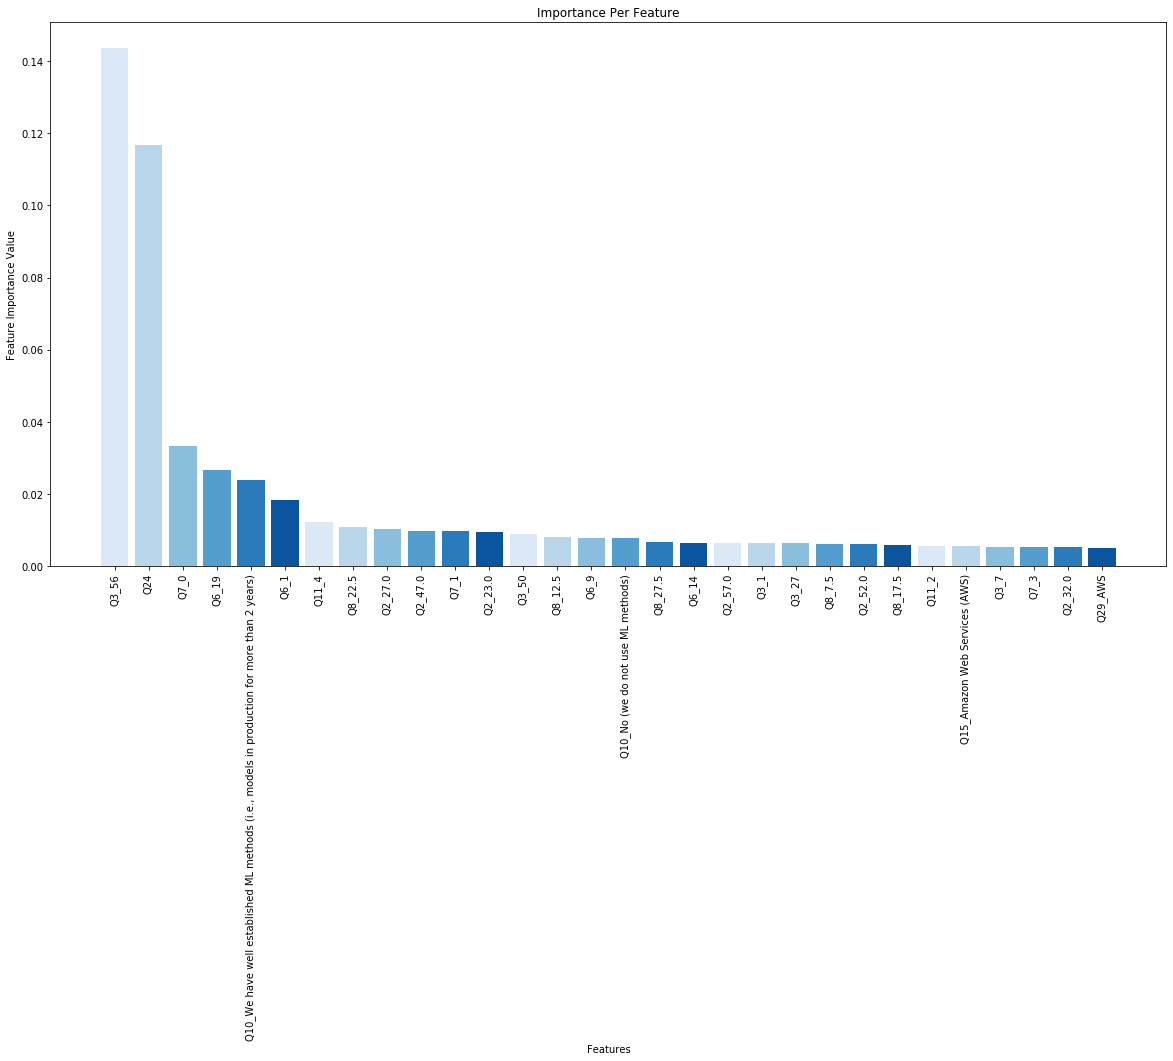

In [267]:
#Plot feature importnance scores 
colors=sns.color_palette('Blues')
plt.figure( figsize=(20,10) )
plt.bar(top_features.index,top_features['Feature_Importance'],color=colors)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature Importance Value')
plt.title('Importance Per Feature')
plt.show()